## Imports

In [1]:
import pickle
import theano
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import seaborn as sns
import multiprocessing as mp
from theano import tensor as tt
from matplotlib import pyplot as plt
from threadpoolctl import threadpool_limits
from datetime import datetime

### Miscelaneous configurations

In [2]:
%env THEANO_FLAGS=device=cpu,floatX=float32
%env OMP_NUM_THREADS=1
#%env MKL_NUM_THREADS=1
%config InlineBackend.figure_format = 'retina'

env: THEANO_FLAGS=device=cpu,floatX=float32
env: OMP_NUM_THREADS=1


In [3]:
plt.rcParams['font.family'] = 'Serif'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
start = datetime.now()
output_dir = 'output/HBGLM'

## Exploratory Data Analyses

Loading the data from the `glm.csv` file:

In [4]:
# Loading the data and renaming some columns
col_names = {'sexo': 'sex', 'temporada': 'temp', 'estadio':'est'}
# Drop unused columns and missing data
glm_data = pd.read_csv('data/glm.csv').rename(columns = col_names).dropna()
glm_data.head()

sp  year    temp sex      est       d15n       d13c
0  H.dipterurus  2015  Calida   M  Juvenil  16.301217 -14.506785
1  H.dipterurus  2015  Calida   H  Juvenil  16.832374 -17.810405
2  H.dipterurus  2015  Calida   M   Adulto  17.135463 -15.831434
3  H.dipterurus  2015  Calida   H  Juvenil  13.123093 -15.965960
4  H.dipterurus  2015  Calida   M   Adulto  17.633117 -16.719438

In [5]:
# Means and sample size by group
glm_data.groupby(['sp', 'year', 'temp', 'sex', 'est']).agg({'d13c': 'mean', 'd15n': ['mean', 'count']})

d13c       d15n      
                                              mean       mean count
sp              year temp   sex est                                
H.dipterurus    2015 Calida H   Adulto  -13.942144  16.613670     9
                                Juvenil -14.017620  15.994767    23
                            M   Adulto  -14.998469  16.604050    22
                                Juvenil -13.373202  15.680330     9
                     Fria   H   Adulto  -13.064860  14.864662     3
                                Juvenil -12.610936  13.877340     9
                            M   Adulto  -11.927432  16.407116     2
                                Juvenil -14.407406  14.484665     4
N.entemedor     2015 Calida H   Adulto  -12.359643  18.205161    30
                                Juvenil -12.812716  17.831336    10
                            M   Adulto  -12.847007  18.135719    12
                                Juvenil -10.295426  16.573227     2
                     Fria   H   Adulto  -12.030624  17.699466    13
                                Juvenil -12.194370  16.500017     2
R.steindachneri 2015 Calida H   Adulto  -15.779771  16.400239     3
                                Juvenil -13.170622  14.434994     2
                            M   Adulto  -15.236513  15.746496    13
                                Juvenil -12.943184  13.869374     1
                     Fria   M   Adulto  -14.953427  14.627732     1
                                Juvenil -16.390769  16.749110     1
                2016 Calida H   Adulto  -15.486790  16.510650     2
                                Juvenil -16.418847  16.186230    23
                            M   Adulto  -16.489796  16.459579     7
                                Juvenil -16.166709  16.014685    20
                     Fria   H   Juvenil -15.006439  14.493645     1

### Data description

In @fig-pairplot we can observe that:

1. There is an isotopic gradient between the three species in both isotopes: *R. steindachneri* < *H. dipterus* < *N. entemedor*.

2. This gradient is consistent, to different extents, through the covariates, causing deviations from the statistic normality, especially in multivariate terms.

3. Some classes are misrepresented in relation to anothers

It is important to mention that the `year` variable has two levels only for *R. steindachneri* and will, hence, be discarded from the analysis.

In [6]:
# Same as before, but without the year variable
glm_data.groupby(['sp', 'temp', 'sex', 'est']).agg({'d13c': 'mean', 'd15n': ['mean', 'std', 'count']})

d13c       d15n                
                                         mean       mean       std count
sp              temp   sex est                                          
H.dipterurus    Calida H   Adulto  -13.942144  16.613670  1.494203     9
                           Juvenil -14.017620  15.994767  1.658766    23
                       M   Adulto  -14.998469  16.604050  1.784481    22
                           Juvenil -13.373202  15.680330  0.976791     9
                Fria   H   Adulto  -13.064860  14.864662  2.659849     3
                           Juvenil -12.610936  13.877340  1.149967     9
                       M   Adulto  -11.927432  16.407116  0.384593     2
                           Juvenil -14.407406  14.484665  1.026919     4
N.entemedor     Calida H   Adulto  -12.359643  18.205161  0.620264    30
                           Juvenil -12.812716  17.831336  1.150832    10
                       M   Adulto  -12.847007  18.135719  0.710318    12
                           Juvenil -10.295426  16.573227  0.649217     2
                Fria   H   Adulto  -12.030624  17.699466  0.585372    13
                           Juvenil -12.194370  16.500017  0.754364     2
R.steindachneri Calida H   Adulto  -15.662578  16.444403  0.209680     5
                           Juvenil -16.158989  16.046131  0.634873    25
                       M   Adulto  -15.675162  15.996075  0.811715    20
                           Juvenil -16.013208  15.912527  1.013169    21
                Fria   H   Juvenil -15.006439  14.493645       NaN     1
                       M   Adulto  -14.953427  14.627732       NaN     1
                           Juvenil -16.390769  16.749110       NaN     1

In [7]:
# Variable coding:
# Sex
n_sex = len(glm_data.sex.unique()) # Número de categorías (2, evidentemente)
glm_data['sex'] = pd.Categorical(glm_data['sex']).codes # Se transforma a 0 y 1
sex_idx = glm_data.sex.values # Se extraen los identificadores

# Season
n_temp = len(glm_data.temp.unique())
glm_data['temp'] = pd.Categorical(glm_data['temp']).codes
sex_idx = glm_data.temp.values

# Age
n_est = len(glm_data.est.unique())
glm_data['est'] = pd.Categorical(glm_data['est']).codes
sex_idx = glm_data.est.values

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


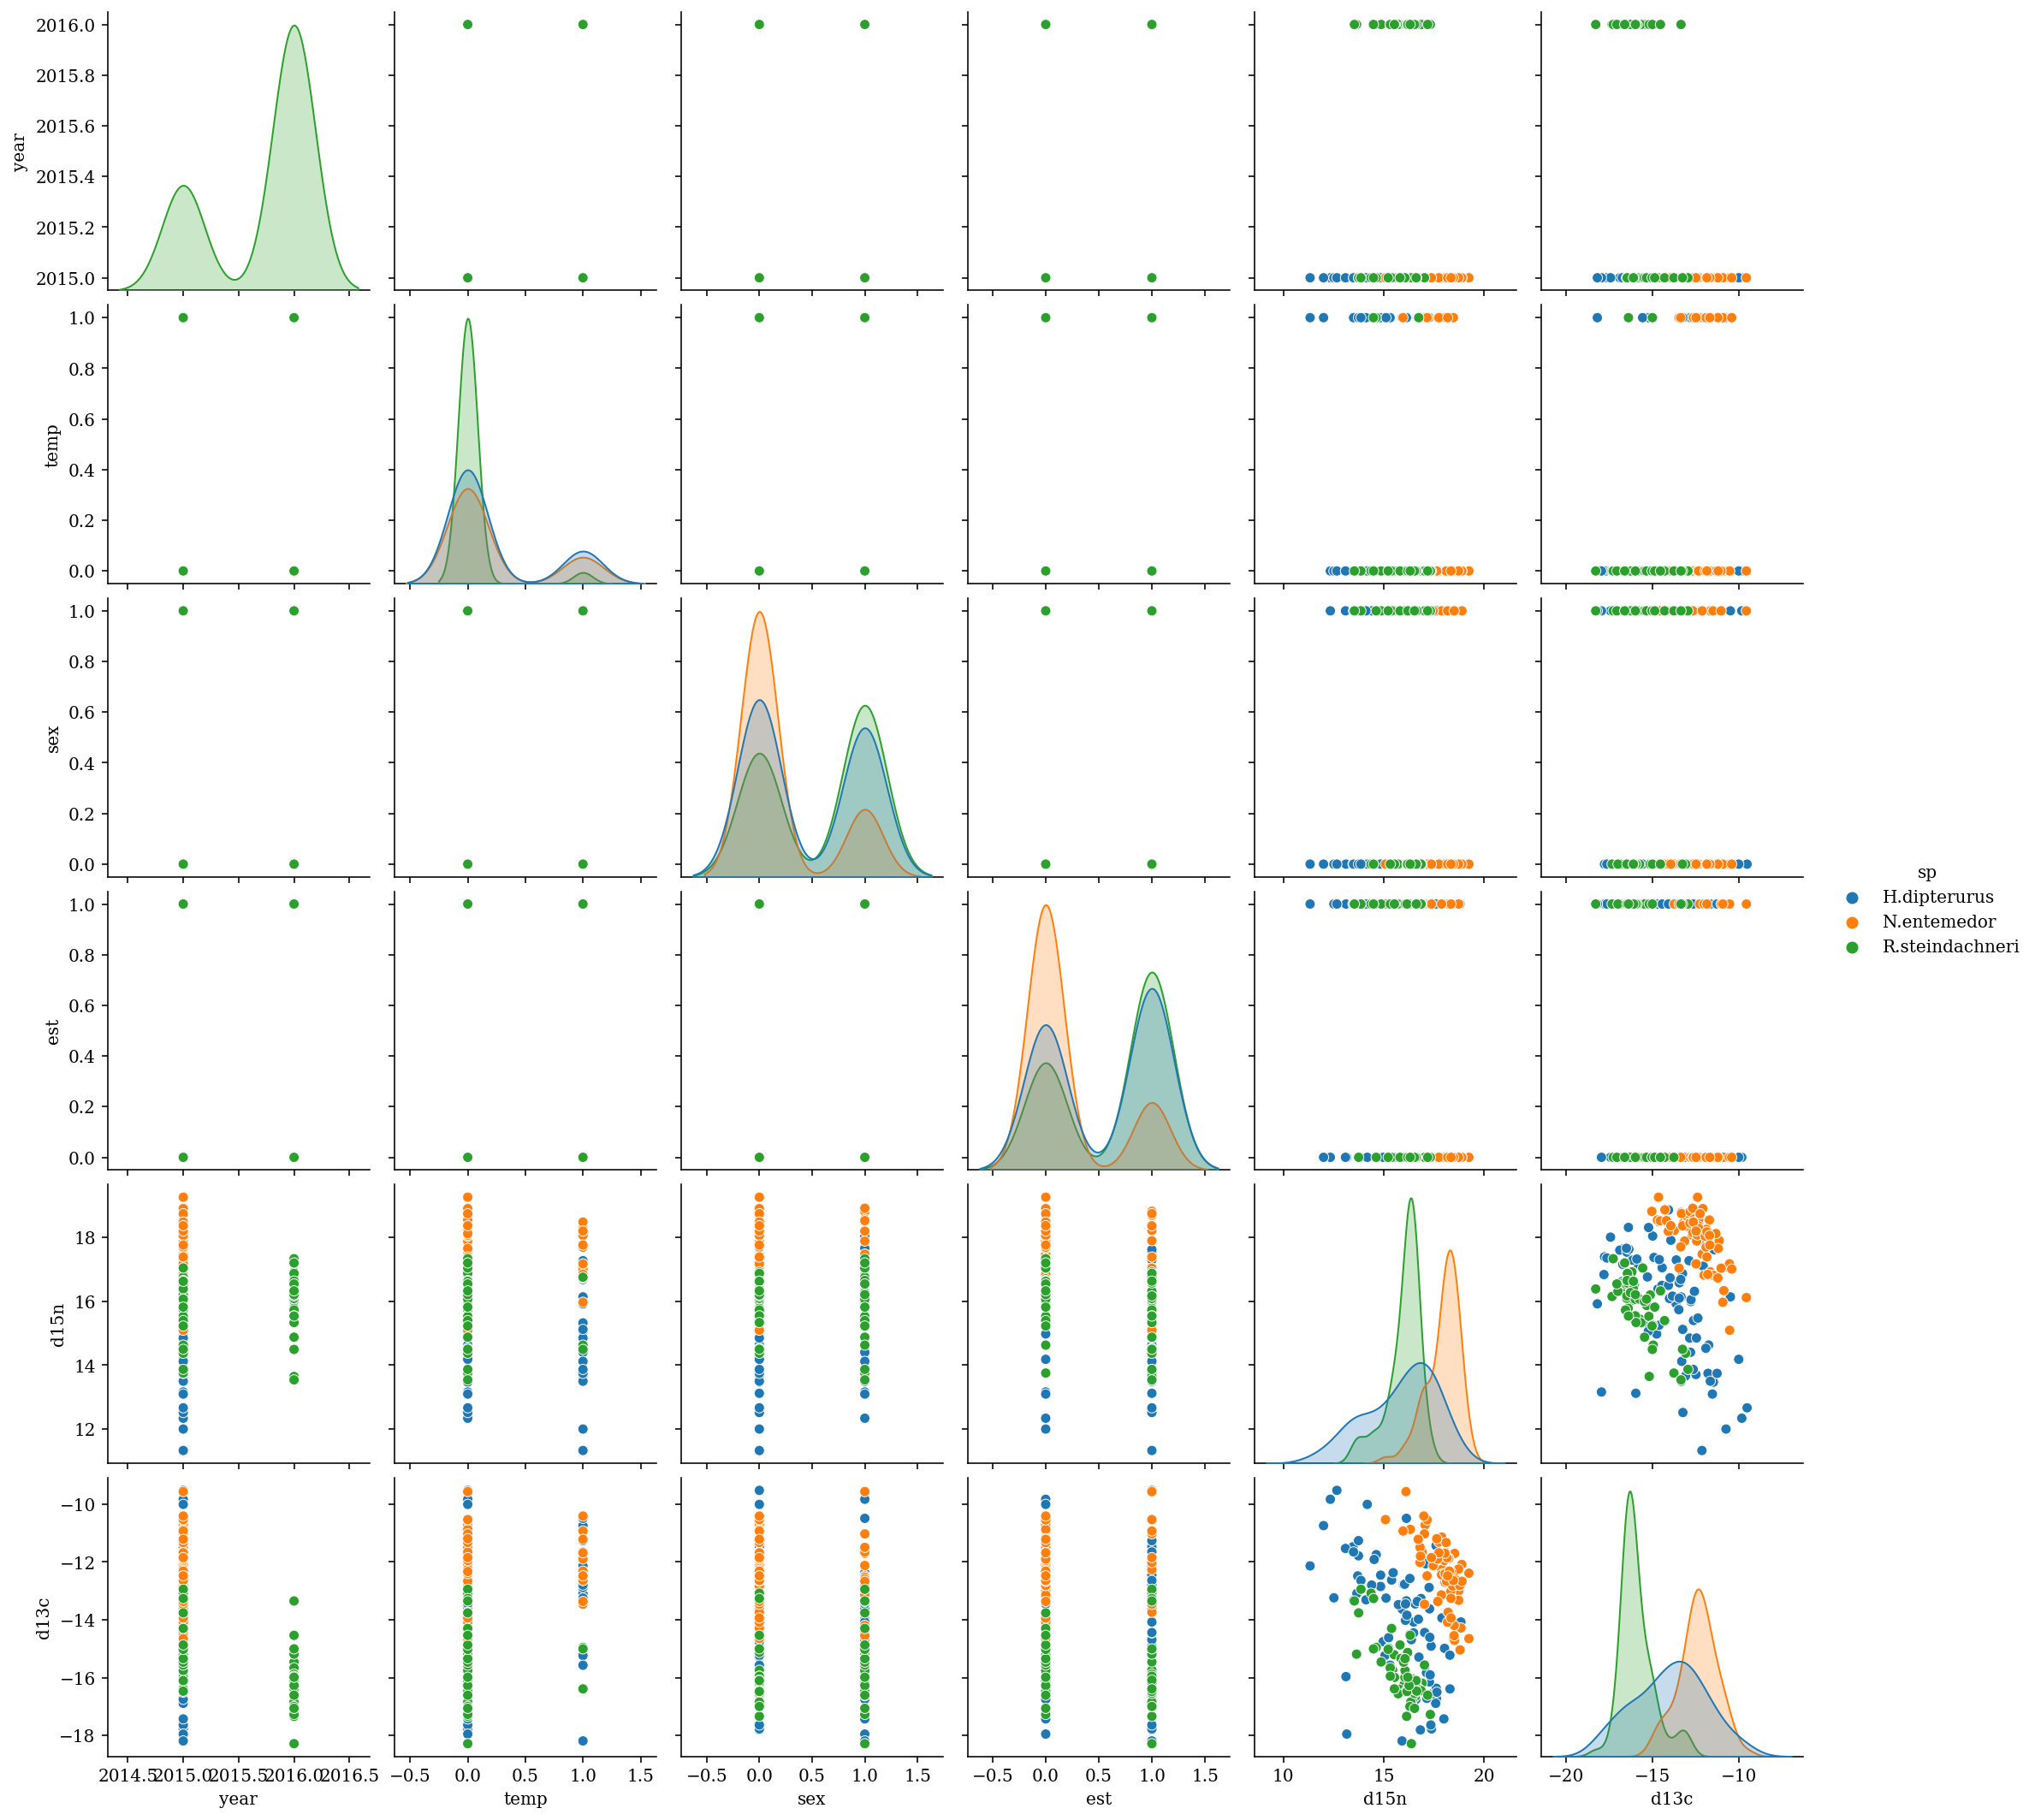

In [8]:
#| label: fig-pairplot
#| fig-cap: "Pairplot of isotopic data and covariates"
#| warning: false
_ = sns.pairplot(glm_data, hue = 'sp', palette = colors[0:3], corner = False)

In [9]:
# Species
n_sp = len(glm_data.sp.unique())
sp_names = glm_data['sp'].unique()
glm_data['sp'] = pd.Categorical(glm_data['sp']).codes
sp_idx = glm_data.sp.values

## Justification of methods

Frequentist null hypothesis testing has been useful in ecological studies; however, it has been suggested that inferences should, instead, be made from models, likelihodd ratios or in probabilistic terms (*i.e.* Bayesian Inference [@Gerrodette_2011; @Ellison_2004; @HobbsHilborn_2006; @Armheinetal_2019]); hence, analyses were based on Bayesian Inference. In general, Bayesian Inference consists on the reallocation of credibility among a space of candidate possibilities, using the Bayes' Theorem to evaluate the credibility of a parameter given the data and prior knowledge of the parameter [@Bolstad_2004; @Kruschke_2015]. Details on the implementation of the models and the sampling of the posterior distributions are given in each section; however, each model was run until convergence; *i.e.*, 0 divergences during the posterior sampling and Gelman-Rubick statistics equal to 1.0 for every parameter. Other graphical diagnostics such as Posterior Predictive Checks and energy plots [@Betancourt_2017; @Gabryetal_2017] are also presented. Every sample after convergence (posterior) was kept. This approach was taken since thinning the posterior sample is unadvised, unless there are computational restrictions, due to a reduction in the precision of the estimates [@LinkEaton_2012; @Stan_2022]. Still, the number of posterior samples for each model was dependent on the number of independent samples (effective sample sizes, ess) being over 2000, both for bulk and tail ess [affecting the reliability of the median and highest density intervals, respectively, @Martin_2018].

## Comparisons of means and effects of predictors <a class="anchor" id="hierbiv"></a>

The isotopic spaces of the three species were described using a custom hierarchichal bivariate model, in which the effects of the climatic seasons (warm vs. cold), sexes and age categories (juveniles vs. adults) on the isotopic values are nested within each species, meaning that the isotopic space of each species is the result of two linear models (one per isotopic ratio) of the covariates. This model was implemented using the `pymc3` library [v. 3.11.2, @Salvatieretal_2016] in Python 3 [v. 3.8.2, @VanRossumetal_2009], with three chains that were tuned for 25,000 iterations and a posterior sample of 2,000 iterations (draws). The model was specified as follows, where $j$ represents the isotopic ratio, $i$ the species, $a$ the intercept (*i.e.* the mean isotopic value) and $b$ the slopes of the regression (*i.e.* the difference between both levels of the covariates):

- **Hyper-priors**
    - $\nu \sim Exponential(\lambda = 1/29)+1$: global degrees-of-freedom (d.f.). The shifted exponential distribution spreads the credibility both for nearly normal and heavy-tailed distributions [@Kruschke_2012].
    - $\mu_j \sim StudentT(\mu = mean(data_j), \sigma = sd(data_j)*1000, \nu$): Global mean of each isotope, centered on the mean of the pooled data for each isotope and a standard deviation 1000 times that of the pooled data, with the previously described d.f.
    - $\sigma_{j,a} \sim HalfCauchy(\beta = 10)$: global standard deviation of the intercepts, following a non-commital Half-Cauchy distribution.
    - $\sigma_{j,b} \sim HalfCauchy(\beta = 10)$: global standard deviation of the slopes, with the same distribution as that of the intercepts.
    - $\mu_{j,b} \sim StudentT(\mu = 0, \sigma = 10, \nu)$: global mean of the slopes, following a non-commital Student-T distribution with the previouslu described d.f.

- **Parameter priors**
    - $\nu_i \sim Exponential(\lambda = 1/29) + 1$: Degrees-of-Freedom for each species, with the same specification that the global d.f.
    - $Sigma_i \sim LKJCholesky(n = 2, \eta = 1, \sigma = HalfCauchy(\beta = 10))$: Covariance matrix for both isotopes for each species, following a Cholesky-decomposed LKJ prior with equi-probability for every matrix, and each standard deviation following a non-commital Half-Cauchy distribution. Used instead of the Wishart distribution due to its higher efficiency to compute when paired with a Cholesky decomposition [@Lewandowskietal_2009].
    - $\mu_{j,i} \sim StudentT(\mu = \mu_j, \sigma_{j,a}, \nu_i)$: Intercepts of the linear model for each species and isotopic ratio; *i.e.*, the mean of each isotopic ration with a standard daviation $\sigma_{j,a}$ and d.f. $nu_i$.
    - $\beta_{j,b,i} \sim Laplace(\mu_{j,b,i}, b = \sigma_{j,i})$: Represents the slope for each isotope and species, following a Laplace distribution, which results in a L1 regularization (*i.e.* a "Bayesian Lasso" [@ParkCasella_2012]), with parameters:
        - $\mu_{j,b,i} \sim StudentT(\mu_{j,b}, \sigma_{j,b}, \nu_i)$: distribution of means of the intercept for each isotopic ratio, following a Student T distribution with mean 0, standard deviation 10 and d.f. $\nu_i$.
        - $\sigma_{n,j,i} \sim HalfCauchy(\beta = 10)$: scale of the Laplace distribution, following a non-commital Half-Caucy distribution.

- **Likelihood model**
    - $Y_i \sim MvStudentT(\mu = [y_{1,i}, y_{2,i}], \Sigma_i, \nu)$: The bivariate distribution of the isotopic values following a Multivariate Student T distribution, with covariance matrix $\Sigma_i$, d.f. $\nu$ and means under the linear model:
        - $y_{j,i} = \mu_{j,i} + \beta_{1,j,i}*Sex + \beta_{2,j,i}*Season + \beta_{3,j,i}*Age$
    
This parametrization obeyed the following reasons: i) a bivariate model allows accounting for the covariation between bulk isotopic values, which is relevant since these depend both on the isotopic baseline and the trophic level; hence, having a joint distribution that is not orthogonal; and, ii) the distributions used have heavier tails than a normal distribution, which assigns a higher probability to extreme values and, thus, allows to make robust estimations of the parameters [@Kruschke_2012].

In [10]:
with pm.Model() as full_model:
    
    obs = glm_data[['d13c', 'd15n']].values
    
    #----Hyper-priors----
    ## Degrees of freedom.
    # Shifted exponential to spread the credibility among heavy-tailed
    # (small d.f.) and light-tailed (d.f) distributions (normal-like)
    nu = pm.Exponential('ν', lam = 1/29) + 1
    
    ## Mean Isotopic values ~ StudentT (Gaussian-like, heavier tails than a normal dist.)
    # Centered on the global mean of each isotope to keep the distribution scaled
    # Standard deviation: 1000 times the standard deviation of the pooled data
    # D.F.: Previously defined
    
    µ1 = pm.StudentT('δ13C', mu = glm_data.d13c.mean(),
                     sd = glm_data.d13c.std()*1000,
                     nu = nu)
    µ2 = pm.StudentT('δ15N', mu = glm_data.d15n.mean(),
                     sd = glm_data.d15n.std()*1000,
                     nu = nu)    
    ## Parameters
    # Standard deviation of the intercepts. Non-commital Half-Cauchy.
    sigma_a = pm.HalfCauchy('sd_a', beta = 10)
    
    # Standard deviation of the slopes. Non-commital Half-Cauchy.
    sigma_b = pm.HalfCauchy('sd_b', beta = 10)
    
    # D.F. of the Distribution. Same parametrization as before.
    nu2 = pm.Exponential('nu_a', lam = 1/29) + 1
    
    # Distribution of means of the slopes. Non-commital Student-T distribution.
    mu_b = pm.StudentT('mu_b', mu = 0, sd = 10, nu = nu)
    
    #----Priors on the parameters----
    ## Means: Student-T
    mu1 = pm.StudentT('µδ13C',
                      mu = µ1,
                      sigma = pm.HalfCauchy('sδ13C', beta = 10),
                      nu = nu2,
                      shape = n_sp)
    mu2 = pm.StudentT('µδ15N',
                      mu = µ2,
                      sigma = pm.HalfCauchy('sδ15N', beta = 10),
                      nu = nu2,
                      shape = n_sp)
    
    ## Intercepts: Student-T distribution centered on global mean isotopic values
    a1 = pm.StudentT('⍺δ13C', mu = µ1, sigma = sigma_a, nu = nu2, shape = n_sp)
    a2 = pm.StudentT('⍺δ15N', mu = µ2, sigma = sigma_a, nu = nu2, shape = n_sp)
    
    ## Slopes: Student T distribution   

    ## Slopes: Laplace distribution. 
    # Equivalent to a Lasso regression; i.e., L1 regularization.
    # Affects the sum of absolutes of the residuals. The effect is that small effects -> 0.
    # Especially useful when considering the measuring error of the mass spectrometer.
    
    # Main effects:
    # Sex:
    T_b1c = pm.Laplace('Sex_δ13C', mu = mu_b, b = sigma_b, shape = n_sp)
    T_b1n = pm.Laplace('Sex_δ15N', mu = mu_b, b = sigma_b, shape = n_sp)
    # Season:
    T_b2c = pm.Laplace('Temp_δ13C', mu = mu_b, b = sigma_b, shape = n_sp)
    T_b2n = pm.Laplace('Temp_δ15N', mu = mu_b, b = sigma_b, shape = n_sp)
    # Maturity stages:
    T_b3c = pm.Laplace('Age_δ13C', mu = mu_b, b = sigma_b, shape = n_sp)
    T_b3n = pm.Laplace('Age_δ15N', mu = mu_b, b = sigma_b, shape = n_sp)
    
    
    ## Covariance Matrix
    # LKJ prior with eta = 1, meaning a uniform distribution of the whole matrix
    # Prior of every sd: Non-commital Half-Cauchy
    pL = pm.LKJCholeskyCov('pL', n = 2, eta = 1, 
                           sd_dist = pm.HalfCauchy.dist(beta = 10), shape = n_sp)
    # The LKJ distribution is decomposed by a Cholesky factor, so we decompose it:
    L = pm.expand_packed_triangular(2, pL)
    Σ = pm.Deterministic('Σ', L.dot(L.T))
    
    #----Algebraic expression of the model----
    # Each isotope is a linear model with the effect of the covariates
    d13c = a1[sp_idx] +\
           T_b1c[sp_idx]*glm_data.sex.values +\
           T_b2c[sp_idx]*glm_data.temp.values +\
           T_b3c[sp_idx]*glm_data.est.values
    d15n = a2[sp_idx] +\
           T_b1n[sp_idx]*glm_data.sex.values +\
           T_b2n[sp_idx]*glm_data.temp.values +\
           T_b3n[sp_idx]*glm_data.est.values
    
    # Bivariate tensor for the Likelihood model:
    glm = tt.stack([d13c, d15n]).T
    mus = tt.stack([mu1[sp_idx], mu2[sp_idx]]).T
    
    #----Likelihood model----
    # In this step the hierarchical estimates are included;
    # hence, it includes their uncertainty.
    y = pm.MvStudentT('mvT_sp',
                      mu = glm,# Linear model of each isotopes
                      cov = Σ, # Covariance Matrix
                      nu = nu, # Degrees of freedom
                      observed = obs) # Observed data
    
    means = pm.MvStudentT('µ_sp',
                          mu = mus,
                          cov = Σ,
                          nu = nu,
                          observed = obs)

Graph of the hierarchical model.

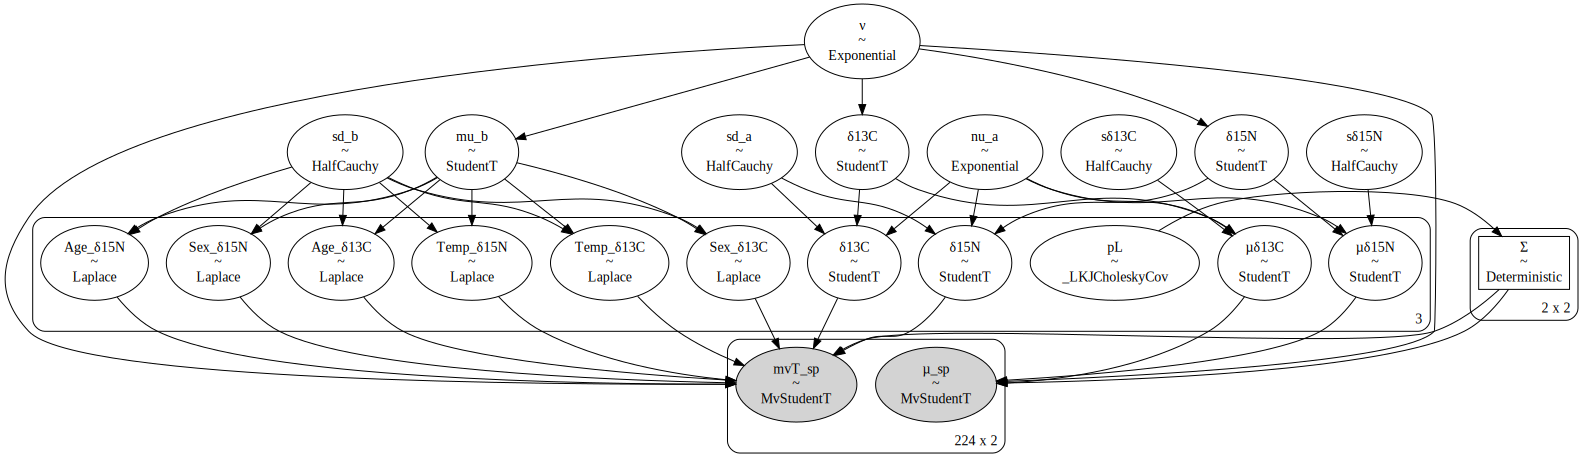

In [11]:
#| label: fig-graph
#| fig-cap: "Directed graph of the hierarchical model."
pm.model_to_graphviz(full_model)

In [12]:
# Parameters of the NUTS.
tune = 25000
draws = 5000
# Variational Inference to start the sampling process
init = 'advi+adapt_diag'

Sampling of the posterior:

In [13]:
with full_model:
    #----Sampling----
    full_trace = pm.sample(draws = draws, # Posterior samples to keep
                           tune = tune, # Burn-in iterations
                           chains = 3, # Number of chains
                           cores = 3, # Number of chains run in parallel 
                           init = init, # Initiation method,
                           return_inferencedata = False, # NOT return an arviz.InferenceData
                           random_seed = 0, # For consistency
                           progressbar = False) # NOT show a progress bar

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18900
Interrupted at 18,899 [9%]: Average Loss = 1,722.9
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [pL, Age_δ15N, Age_δ13C, Temp_δ15N, Temp_δ13C, Sex_δ15N, Sex_δ13C, ⍺δ15N, ⍺δ13C, µδ15N, sδ15N, µδ13C, sδ13C, mu_b, nu_a, sd_b, sd_a, δ15N, δ13C, ν]
Sampling 3 chains for 25_000 tune and 5_000 draw iterations (75_000 + 15_000 draws total) took 519 seconds.


### Diagnostics <a class="anchor" id="diags"></a>

In [14]:
full_mod = az.from_pymc3(trace = full_trace, model = full_model)

In [15]:
# Save posterior samples
#with open(output_dir+'/model/az_model', 'wb') as model_file:
#    pickle.dump(full_mod, model_file)

In [16]:
# Load posterior samples
with open(output_dir+'/model/az_model', 'rb') as model_file:
    full_mod = pickle.load(model_file)

Summary statistics of the posterior distributions of the parameters. Gelman-Statistic values equal to 1.0 (< 1.01) and Effective Sample Sizes (both Bulk and Tail) over 2000 for every parameter.

In [17]:
#| label: tbl-summary
#| tbl-cap: Summary of the posterior distributions of the parameters.
az.summary(full_mod, hdi_prob = 0.95)

mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
δ13C         -14.270   0.855   -15.962    -12.622      0.010    0.007   
δ15N          16.942   0.727    15.431     18.349      0.010    0.007   
µδ13C[0]     -14.002   0.190   -14.390    -13.641      0.002    0.001   
µδ13C[1]     -12.387   0.127   -12.634    -12.139      0.001    0.001   
µδ13C[2]     -16.121   0.111   -16.339    -15.908      0.001    0.001   
µδ15N[0]      16.166   0.149    15.870     16.461      0.002    0.001   
µδ15N[1]      18.059   0.099    17.868     18.252      0.001    0.001   
µδ15N[2]      16.180   0.088    16.001     16.342      0.001    0.001   
⍺δ13C[0]     -14.715   0.364   -15.459    -14.039      0.005    0.004   
⍺δ13C[1]     -12.387   0.165   -12.715    -12.074      0.002    0.002   
⍺δ13C[2]     -15.826   0.237   -16.280    -15.355      0.003    0.002   
⍺δ15N[0]      16.950   0.268    16.422     17.464      0.004    0.003   
⍺δ15N[1]      18.238   0.123    17.997     18.480      0.002    0.001   
⍺δ15N[2]      16.126   0.179    15.767     16.468      0.002    0.002   
Sex_δ13C[0]   -0.316   0.289    -0.886      0.223      0.003    0.003   
Sex_δ13C[1]   -0.079   0.285    -0.654      0.482      0.003    0.003   
Sex_δ13C[2]    0.071   0.183    -0.313      0.419      0.002    0.002   
Sex_δ15N[0]   -0.027   0.208    -0.432      0.405      0.003    0.002   
Sex_δ15N[1]   -0.170   0.231    -0.640      0.261      0.003    0.002   
Sex_δ15N[2]   -0.000   0.151    -0.310      0.296      0.002    0.002   
Temp_δ13C[0]   0.758   0.380     0.028      1.473      0.004    0.003   
Temp_δ13C[1]   0.228   0.258    -0.283      0.736      0.003    0.002   
Temp_δ13C[2]   0.219   0.436    -0.620      1.122      0.004    0.004   
Temp_δ15N[0]  -1.820   0.300    -2.394     -1.230      0.003    0.002   
Temp_δ15N[1]  -0.435   0.230    -0.875      0.024      0.003    0.002   
Temp_δ15N[2]  -0.460   0.518    -1.523      0.416      0.006    0.005   
Age_δ13C[0]    1.114   0.402     0.309      1.875      0.006    0.004   
Age_δ13C[1]   -0.189   0.305    -0.801      0.396      0.004    0.003   
Age_δ13C[2]   -0.477   0.230    -0.935     -0.040      0.003    0.002   
Age_δ15N[0]   -0.844   0.283    -1.387     -0.279      0.004    0.003   
Age_δ15N[1]   -0.390   0.253    -0.893      0.076      0.003    0.002   
Age_δ15N[2]    0.062   0.166    -0.274      0.387      0.002    0.002   
ν              1.544   0.338     0.945      2.230      0.005    0.003   
sd_a           1.749   0.768     0.674      3.278      0.009    0.007   
sd_b           0.569   0.177     0.268      0.919      0.002    0.002   
nu_a          32.985  30.065     0.161     92.372      0.280    0.229   
mu_b           0.071   0.065     0.000      0.201      0.001    0.000   
sδ13C          2.962   2.409     0.650      6.976      0.030    0.021   
sδ15N          2.000   1.787     0.317      4.960      0.024    0.017   
pL[0]          0.943   0.058     0.826      1.055      0.001    0.001   
pL[1]         -0.470   0.044    -0.556     -0.383      0.001    0.000   
pL[2]          0.558   0.035     0.491      0.626      0.001    0.000   
Σ[0,0]         0.893   0.111     0.682      1.112      0.002    0.001   
Σ[0,1]        -0.445   0.064    -0.572     -0.325      0.001    0.001   
Σ[1,0]        -0.445   0.064    -0.572     -0.325      0.001    0.001   
Σ[1,1]         0.536   0.068     0.404      0.668      0.001    0.001   

              ess_bulk  ess_tail  r_hat  
δ13C            8143.0    5118.0    1.0  
δ15N            6664.0    4586.0    1.0  
µδ13C[0]        9381.0    6177.0    1.0  
µδ13C[1]       10104.0    7274.0    1.0  
µδ13C[2]        8252.0    7033.0    1.0  
µδ15N[0]        9182.0    6696.0    1.0  
µδ15N[1]        9701.0    6328.0    1.0  
µδ15N[2]        7761.0    6385.0    1.0  
⍺δ13C[0]        4532.0    6269.0    1.0  
⍺δ13C[1]        5878.0    5920.0    1.0  
⍺δ13C[2]        5060.0    5758.0    1.0  
⍺δ15N[0]        4425.0    6073.0    1.0  
⍺δ15N[1]        5259.0    6177.0    1.

In [18]:
pps = pm.sample_posterior_predictive(trace = full_trace,
                                     model = full_model,
                                     progressbar=False,
                                     random_seed=0)
posteriors = az.from_pymc3(posterior_predictive = pps,
                           model = full_model)

In [19]:
# Save posterior predictive samples
#with open(output_dir+'/model/posteriors_mvt', 'wb') as post_mvt_file:
#    pickle.dump(posteriors, post_mvt_file)

In [20]:
# Load posterior predictive samples
with open(output_dir+'/model/posteriors_mvt', 'rb') as post_mvt_file:
    posteriors = pickle.load(post_mvt_file)

Posterior Predictive Checks for the likelihood model. The observed distribution (black) is between the posterior predictive samples (blue). Each posterior predictive sample consists on a set with the same number of observations as the original data, generated based on a parameter from the posterior samples.

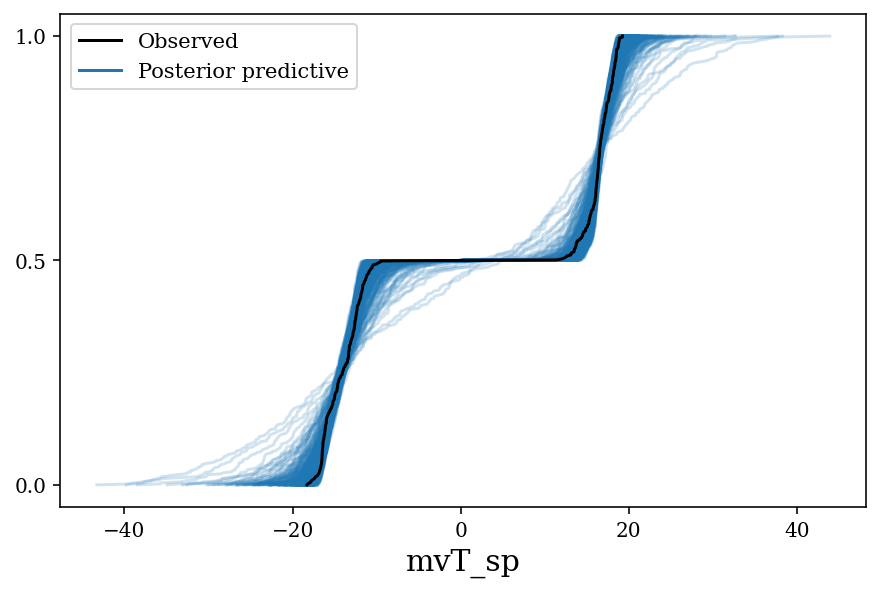

In [21]:
#| label: fig-ppccdf
#| fig-cap: "Posterior Predictive Check using the CDF."
az.plot_ppc(posteriors, mean = False, kind = 'cumulative', num_pp_samples = 500);

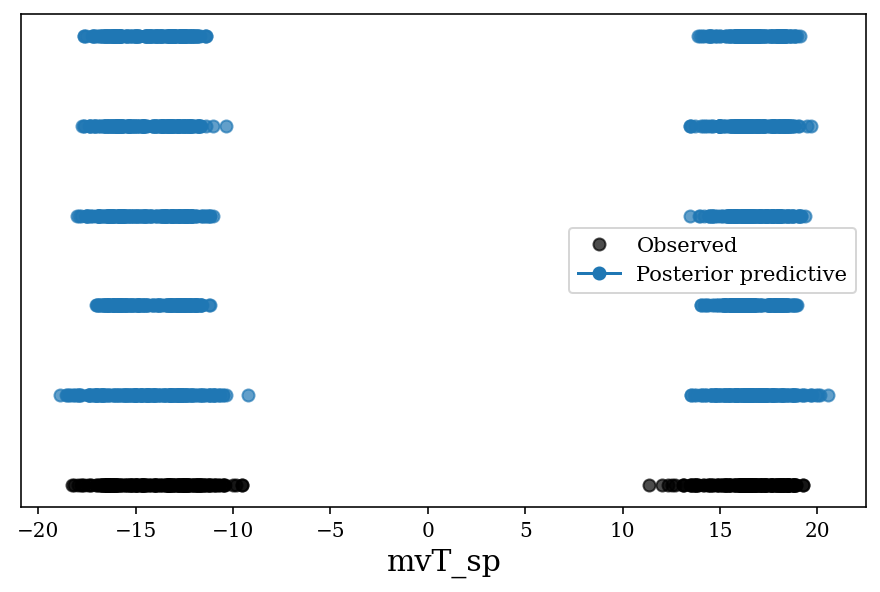

In [22]:
#| label: fig-ppcscatter
#| fig-cap: "Posterior Predictive Check using scatterplots."
az.plot_ppc(posteriors, kind = 'scatter', mean = False);

Energy plot and Bayesian Fraction of Missing Information (BFMI). The energy plot shows similar densities between the marginal and transition energies from the Hamiltonian simulation, meaning that the sampler was not stuck in a particular area of the posterior distribution, which is validated through the BFMI values [@Betancourt_2017].

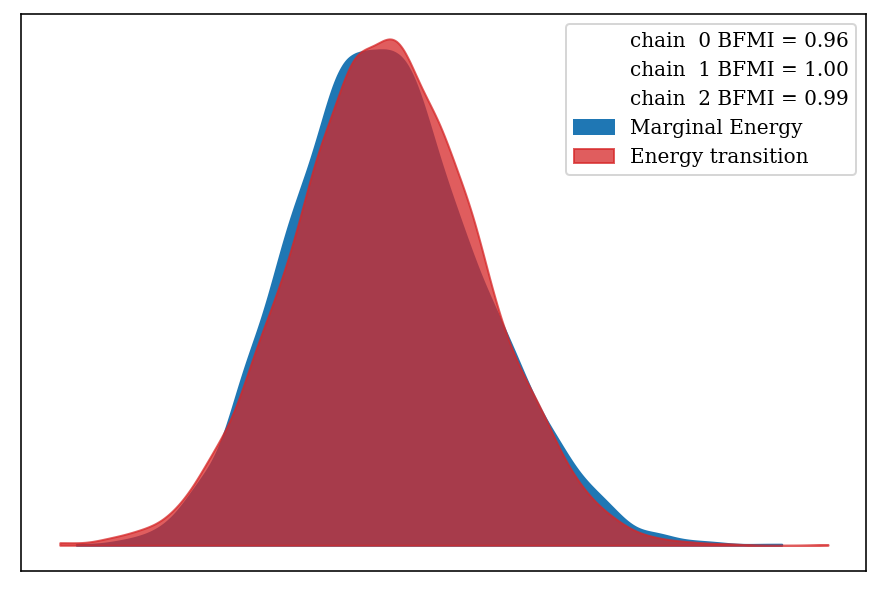

In [23]:
#| label: fig-energy
#| fig-cap: "Energy plot and Bayesian Fraction of Missing Information."
az.plot_energy(full_mod, fill_color = ('C0', 'C3'));

#### Effective sample sizes, autocorrelations and no-thinning.

The autocorrelation (*i.e.*, the correlation between the sample$_i$ and the sample$_{i-1}$) directly affects the effective sample size (ess) estimation (higher autocorrelations, lower ess). For this reason, a very common practice is to thin the posterior sample (*i.e.* keep only 1 out of every k-th iteration after convergence); however, this is unadvised since it leads to a reduction in the precision of the estimates[@LinkEaton_2012], making it feasible only to reduce computational requirements [@Stan_2022]. Moreover, one of the advantages of using NUTS is that the samples can be uncorrelated, since the new state of the chain depends more on the probability "surface" rather than the previous position of the particle. Shown in the following autocorrelation plot:

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9082 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9082 missing from current font.
  font.set_text(s, 0, flags=flags)


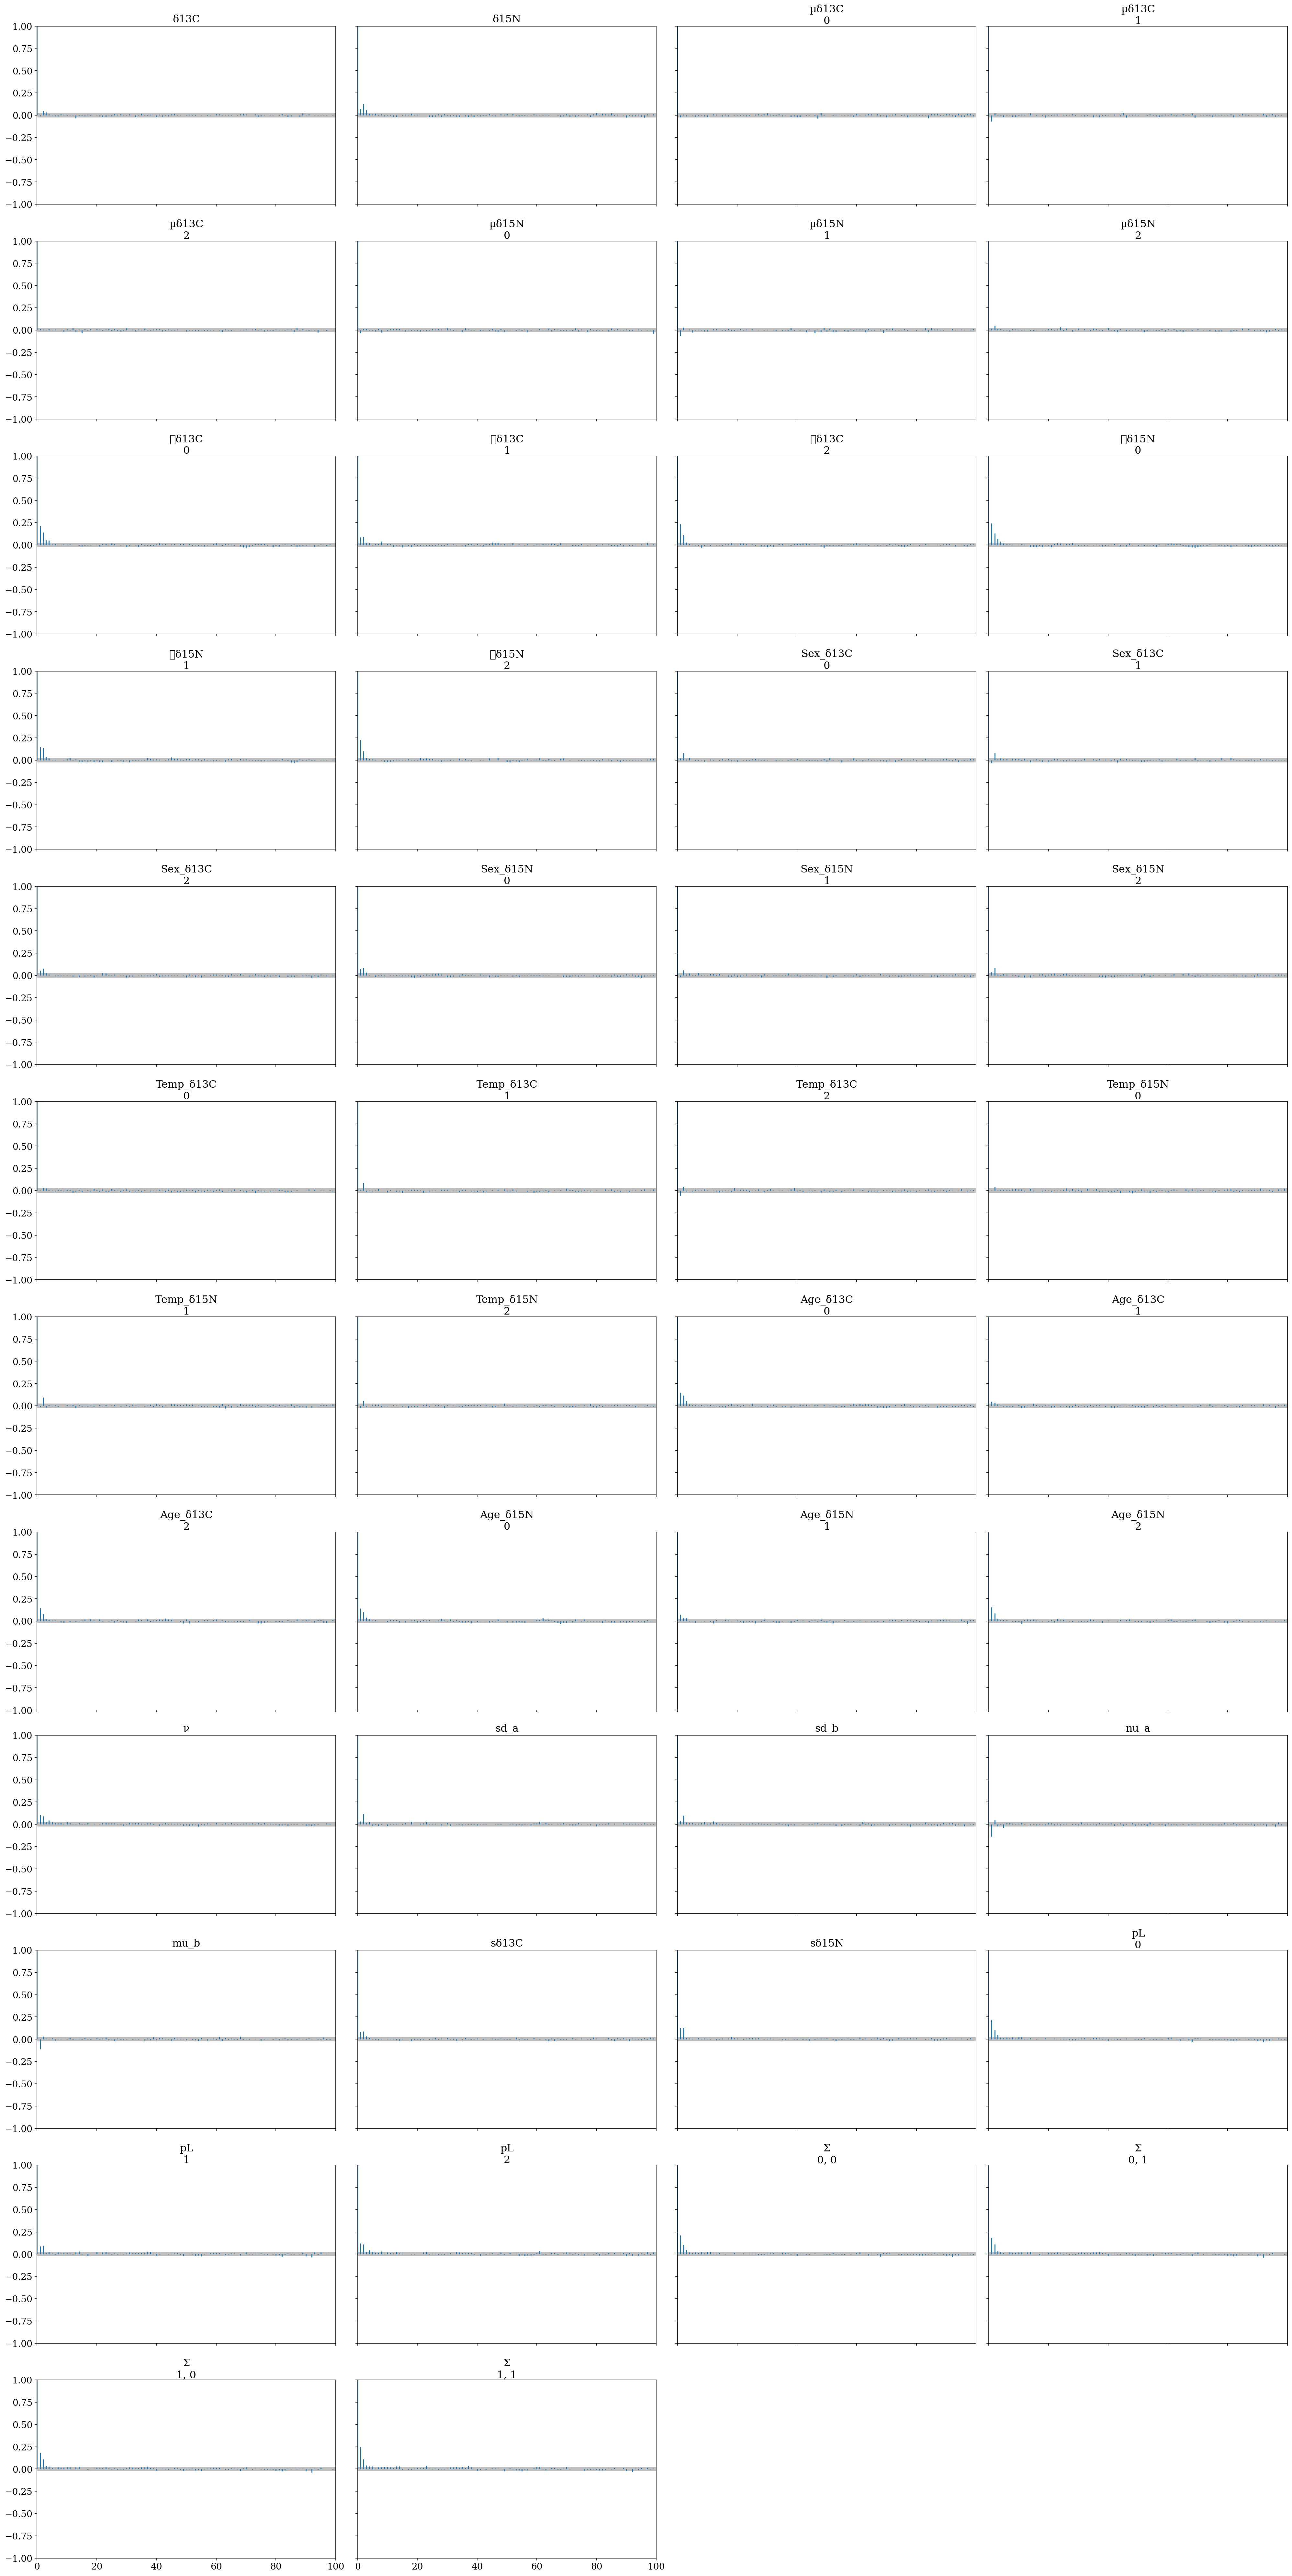

In [24]:
#| label: fig-autocor
#| fig-cap: "Plots of autocorrelations of the posterior sample."
#| warning: false
rc = {'plot.max_subplots': 120}
az.rcParams.update(rc)
az.plot_autocorr(full_mod, combined = True);

Parallel coordinates plots for each parameter of interest within the model. Shows that every sample of the posterior distribution was non-divergent. A) Mean values for each species and B) Slopes for each covariate for each species; where: 0: *H. dipterus*, 1: *N. entemedor*, 2: *R. steindachneri*

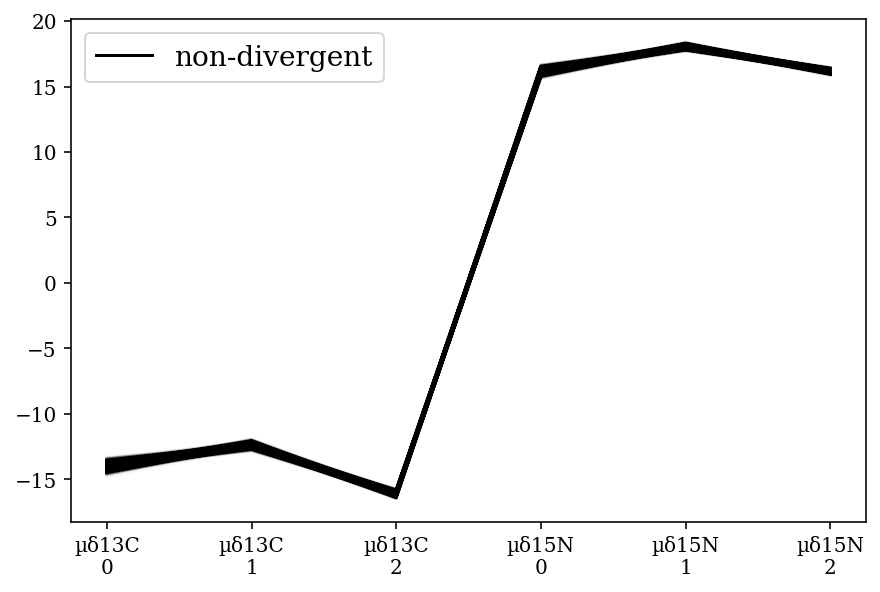

In [25]:
#| label: fig-divmeans
#| fig-cap: "Parallel coordinates plot for the means of the isotopic values."
az.plot_parallel(full_mod, var_names=['µ'], filter_vars='like');

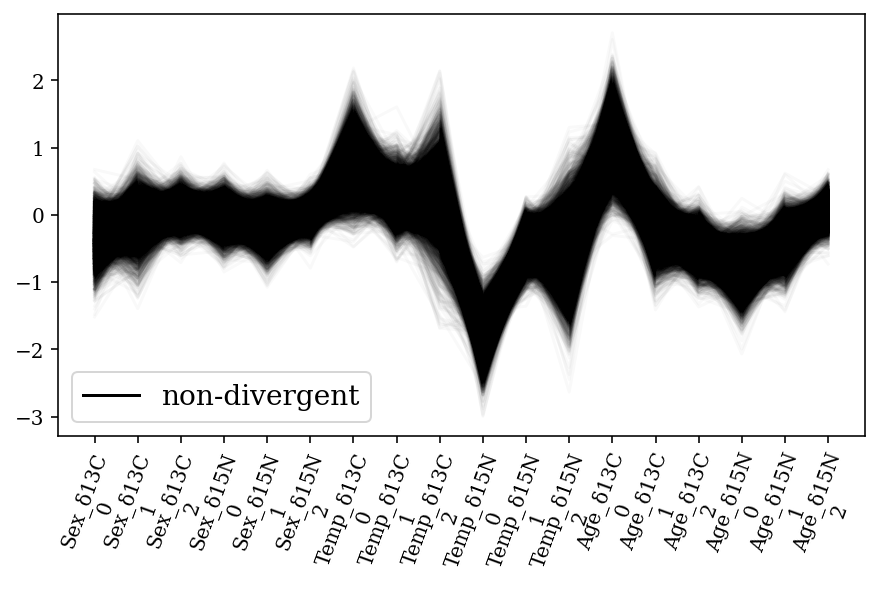

In [26]:
#| label: fig-divslopes
#| fig-cap: "Parallel coordinates plot for the slopes of the covariates."
ax = az.plot_parallel(full_mod, var_names = ['Temp', 'Sex', 'Age'], filter_vars = 'like');
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);

## A note on the interpretation of results <a class="anchor" id="interp"></a>

It is important to understand the interpretation of the slope of a categorical covariate before going to the description of the results. Consider a univariate model with a binary covariate ($X$) such as the ones of this model:

$Y = \beta_0 + \beta_1*X + \epsilon$

$\therefore$

If $X = 0$: $Y = \beta_0 + \beta_1*0 + \epsilon \implies Y = \beta_0 + \epsilon$

If $X = 1$: $Y = \beta_0 + \beta_1*1 + \epsilon \implies Y = \beta_0 + \beta_1 + \epsilon$

*I.e.*, the slope represents the difference between the means of both classes. This is demonstrabe if we substract both equations ($\Delta_Y$):

$Y = \beta_0 + \epsilon = \beta_0 + \beta_1 + \epsilon \implies \Delta_Y = \beta_0 - \beta_0 - \beta_1 + \epsilon - \epsilon \therefore \Delta_Y = -\beta_1$

Taking this into account, the slopes in this work represent the difference (in ‰) between the two classes being analysed.

## Results <a class="anchor" id="resdes"></a>

The blue trace corresponds to *H. dipterus*, the yellow to *N. entemedor* and the green to *R. steindachneri*.

1. $\mu$: Posterior distribution of the means of each species for each isotope. They are among the higher levels on the hierarchy, hence including the uncertainty in the other estimates:

    - $\mu_{\delta^{13}C}$: Shows the separation between species in $\delta^{13}C$. *N. entemedor* shows intermediate values among the other two species.
    
    - $\mu_{\delta^{15}N}$: *Ídem*.

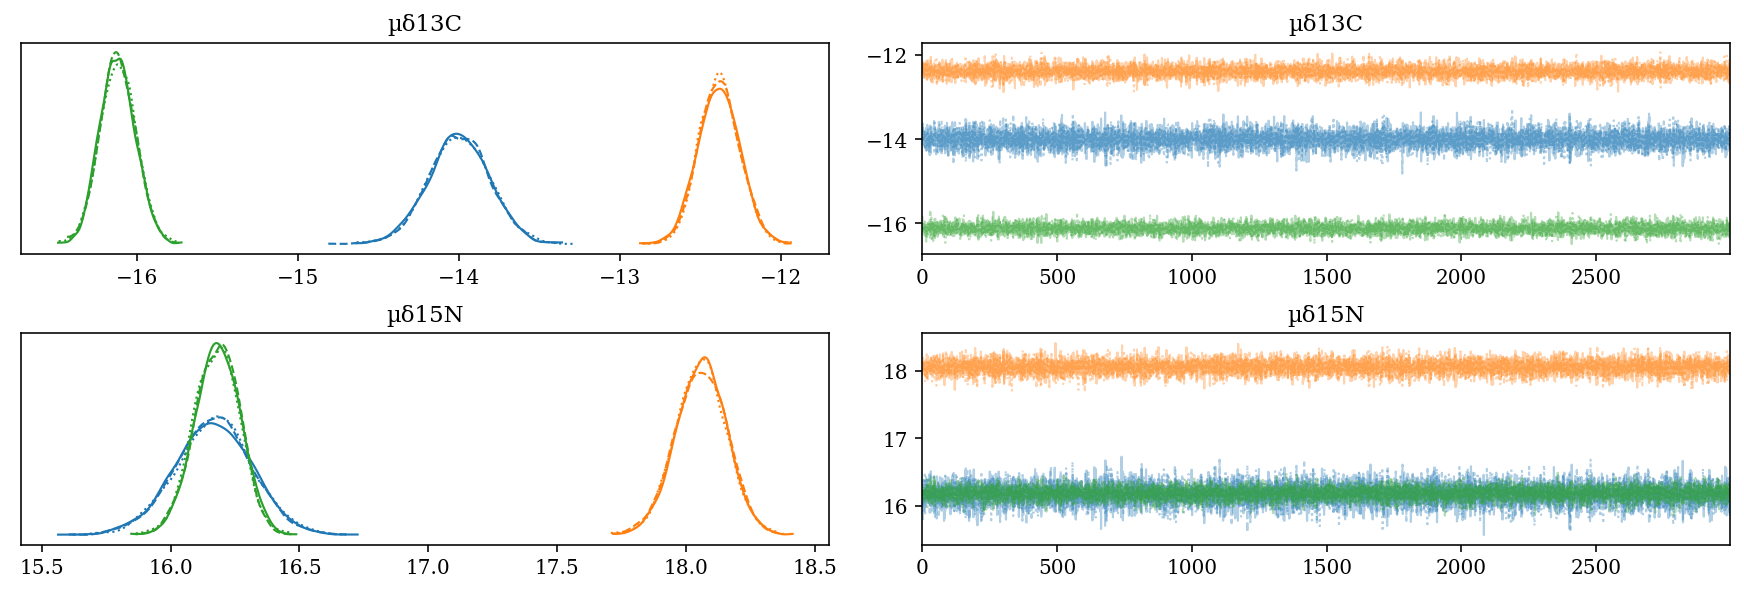

In [27]:
#| label: fig-tracemeans
#| fig-cap: "Trace of the isotopic means for each species."
az.plot_trace(full_mod, var_names = 'µδ', filter_vars = 'like');

2. Sex_: Slope for the sexes of each species for each isotope.
    - Códigos: M = 1, H = 0.
    - The difference between sexes is small ($\approx 0$‰).

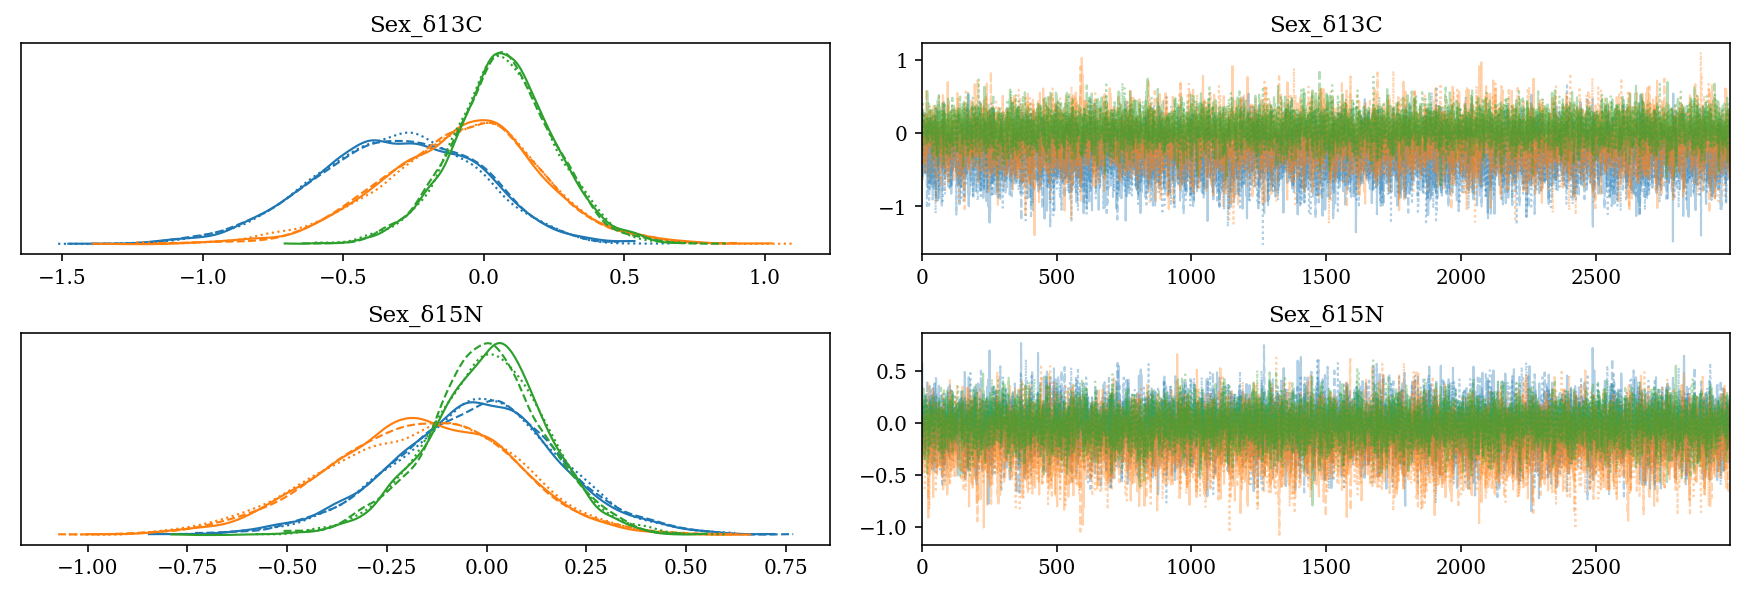

In [28]:
#| label: fig-tracesex
#| fig-cap: "Trace for the slope for the sex."
az.plot_trace(full_mod, var_names = 'Sex', filter_vars = 'like');

3. Temp_: Slope for the season:
    - Códigos: F = 1, C = 0.
    - *H. dipterus*: Difference between seasons of $\approx 1$‰ in $\delta^{13}C$ and $\approx 2$‰ in $\delta^{15}N$.
    - *N. entemedor*: $\Delta^{15}N \in (-1,0)$‰
    - The posterior distributions of *R. steindachneri* are very broad, possibly due to a sample size of three for the cold season.

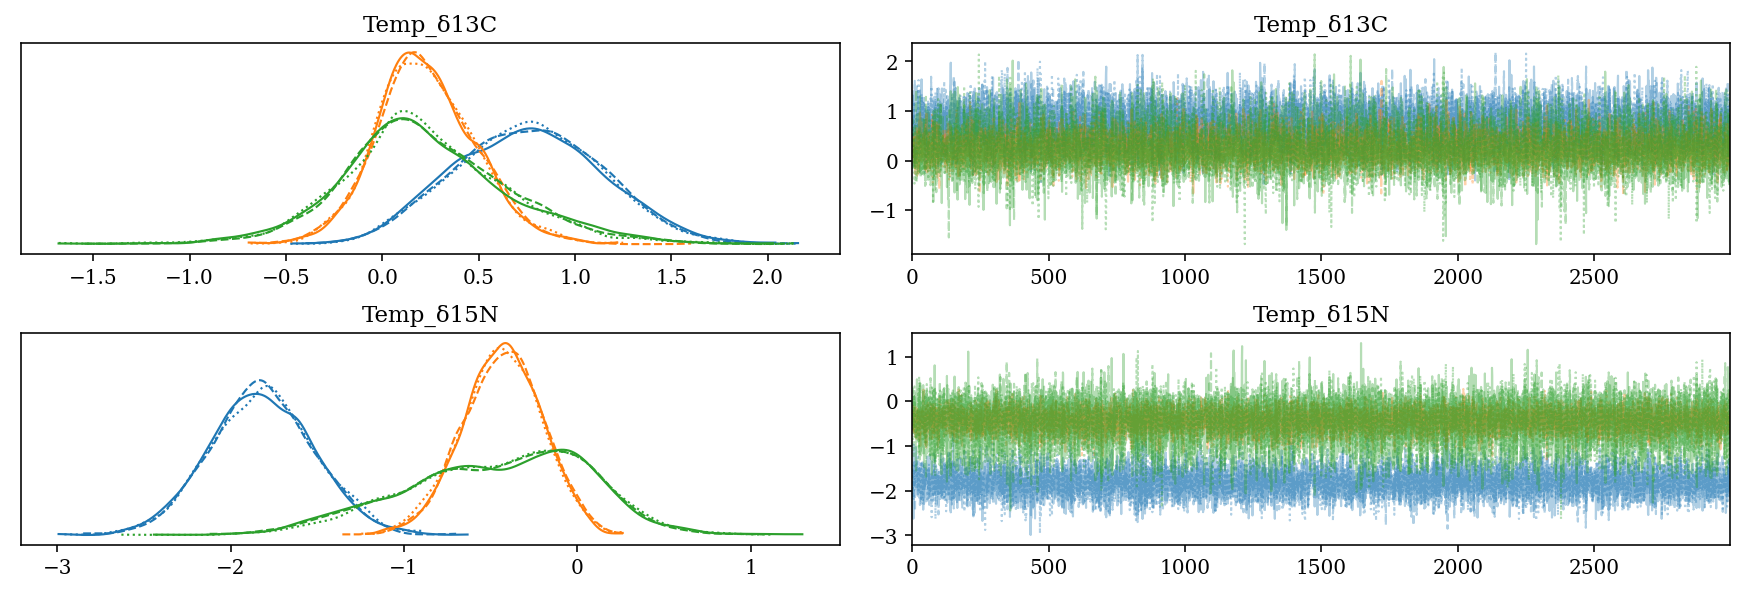

In [29]:
#| label: fig-traceseason
#| fig-cap: "Trace for the slope for the seasons."
az.plot_trace(full_mod, var_names = 'Temp', filter_vars = 'like');

4. Age_: Slope value for the age category of each isotope for each species:
    - Códigos: J = 1, A = 0.
    - *H. dipterus* $\Delta^{13}C \in (0,2)$,  $\Delta^{15}N \in (-1.5,0]$
    - *N. entemedor* $\Delta^{15}N \in [-1.5,0)$
    - *R. steindachneri*: $\Delta^{13}C \in (-1,0)$

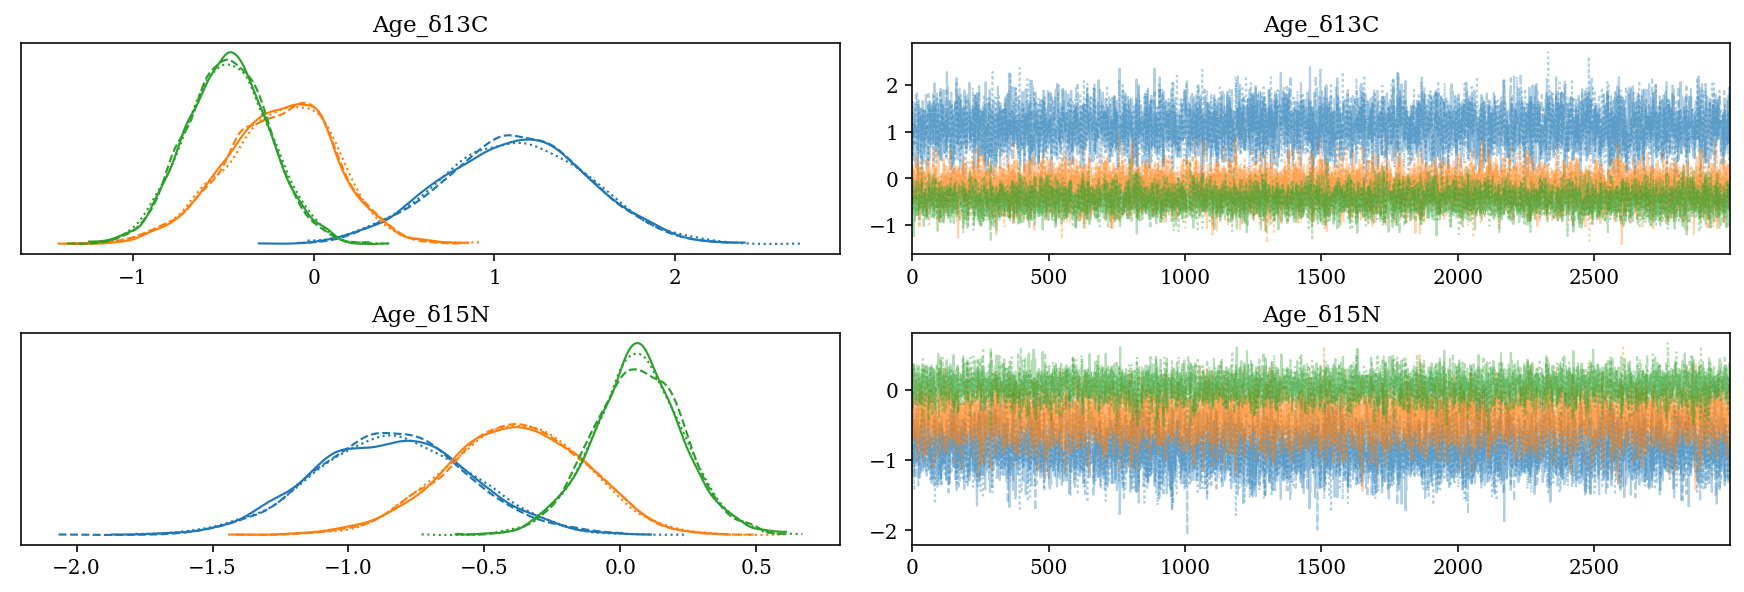

In [30]:
#| label: fig-tracematurity
#| fig-cap: "Trace for the slope for the maturity stages."
az.plot_trace(full_mod, var_names = 'Age', filter_vars = 'like');

Reference: Labels are assigned alphabetically:

In [31]:
orig_data = pd.read_csv('data/glm.csv').rename(columns = col_names).dropna() # eliminamos los NAs

In [32]:
orig_data['sp_codes'] = pd.Categorical(orig_data['sp']).codes
orig_data['temp_codes'] = pd.Categorical(orig_data['temp']).codes
orig_data['sex_codes'] = pd.Categorical(orig_data['sex']).codes
orig_data['est_codes'] = pd.Categorical(orig_data['est']).codes

orig_data

sp  year    temp sex      est       d15n       d13c  \
0       H.dipterurus  2015  Calida   M  Juvenil  16.301217 -14.506785   
1       H.dipterurus  2015  Calida   H  Juvenil  16.832374 -17.810405   
2       H.dipterurus  2015  Calida   M   Adulto  17.135463 -15.831434   
3       H.dipterurus  2015  Calida   H  Juvenil  13.123093 -15.965960   
4       H.dipterurus  2015  Calida   M   Adulto  17.633117 -16.719438   
..               ...   ...     ...  ..      ...        ...        ...   
219  R.steindachneri  2016  Calida   M  Juvenil  13.542301 -13.348383   
220  R.steindachneri  2016  Calida   M   Adulto  16.204549 -15.987939   
221  R.steindachneri  2016  Calida   M   Adulto  16.538663 -17.063799   
222  R.steindachneri  2016  Calida   M   Adulto  17.195018 -16.609368   
223  R.steindachneri  2016  Calida   H   Adulto  16.323223 -14.537800   

     sp_codes  temp_codes  sex_codes  est_codes  
0           0           0          1          1  
1           0           0          0          1  
2           0           0          1          0  
3           0           0          0          1  
4           0           0          1          0  
..        ...         ...        ...        ...  
219         2           0          1          1  
220         2           0          1          0  
221         2           0          1          0  
222         2           0          1          0  
223         2           0          0          0  

[224 rows x 11 columns]

### Inference <a class="anchor" id="inferences"></a>

Figure X. Forest plot of the effects of the covariates on the $\delta^{15}N$ values. Horizontal lines represent the 95% Highest Density Intervals (HDI). Vertical reference line in 0.

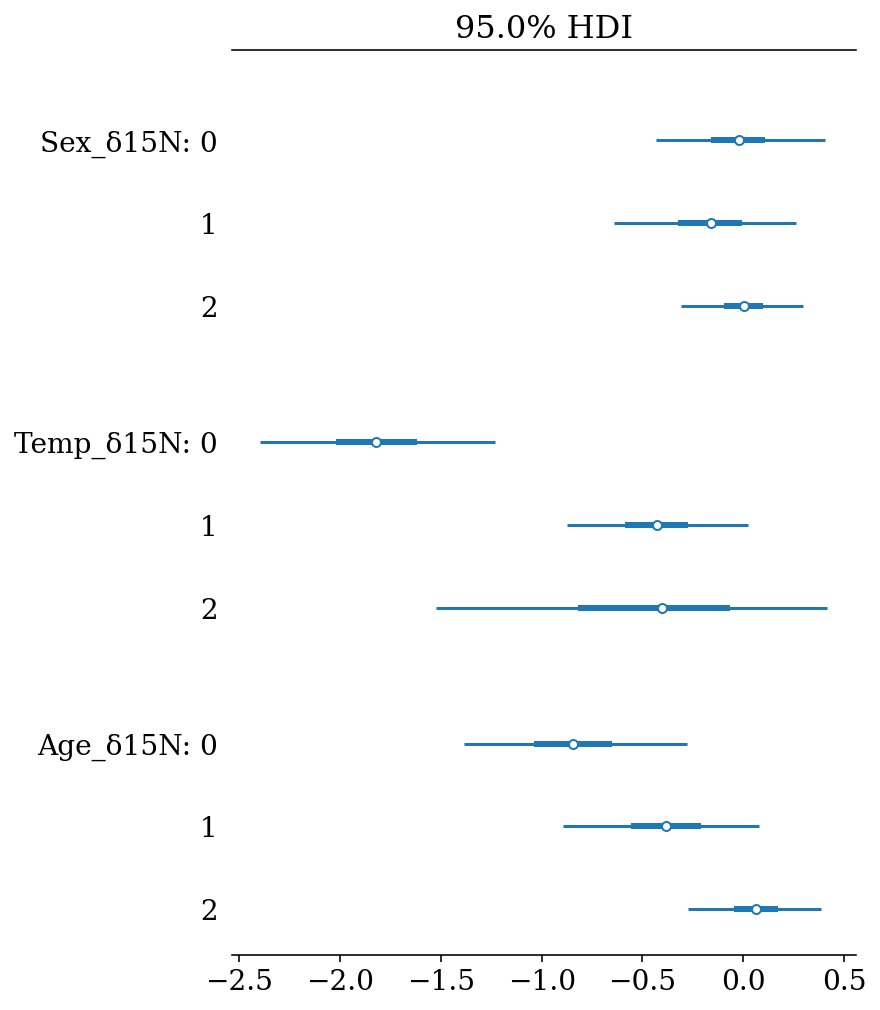

In [33]:
#| label: fig-forestd15n
#| fig-cap: "Forest plot summarising the effects of the covariates on the d15N values."
az.plot_forest(full_mod, hdi_prob = 0.95, var_names = '_δ15N', filter_vars = 'like', combined = True);
#plt.savefig(output_dir+'/figures/d15N_forestplot.pdf', format = 'pdf', bbox_inches = 'tight')

Figure X. Forest plot of the effects of the covariates on the $\delta^{13}C$ values. Horizontal lines represent the 95% Highest Density Intervals (HDI). Vertical reference line in 0.

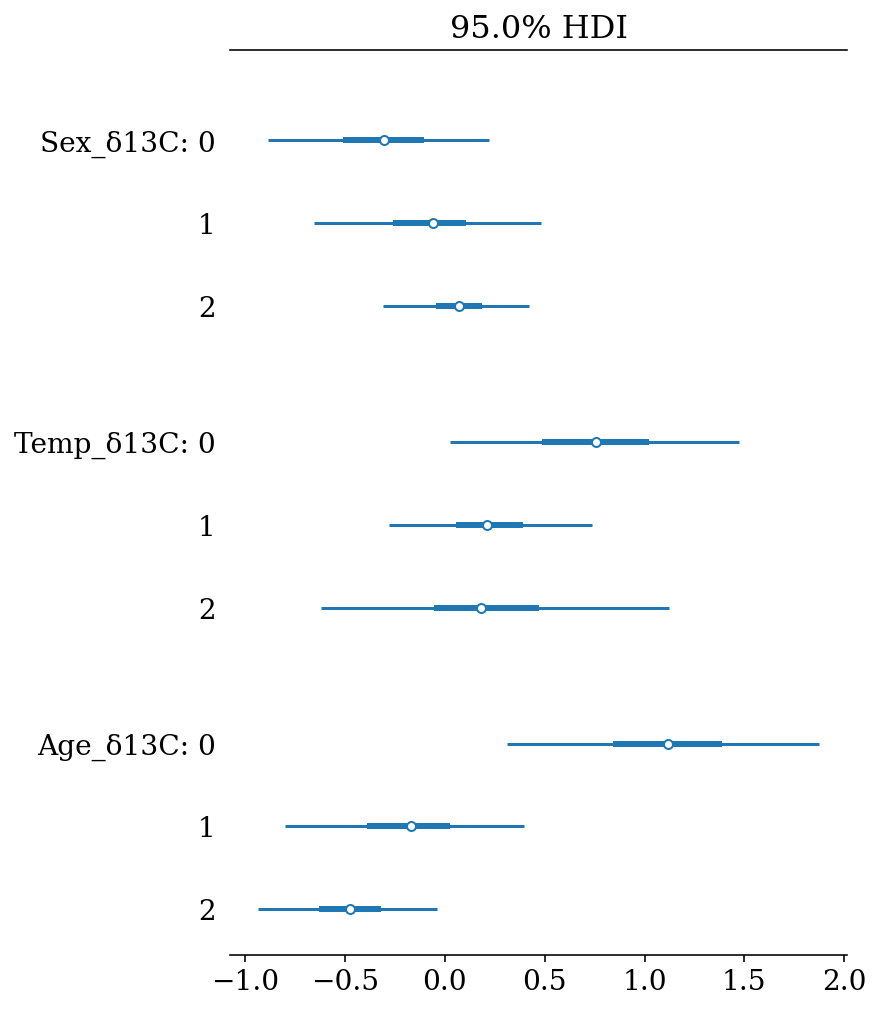

In [34]:
#| label: fig-forestd13c
#| fig-cap: "Forest plot summarising the effects of the covariates on the d13C values."
az.plot_forest(full_mod, hdi_prob = 0.95, var_names = '_δ13C', filter_vars = 'like', combined = True);
#plt.savefig(output_dir+'/figures/d13C_forestplot.pdf', format = 'pdf', bbox_inches = 'tight')

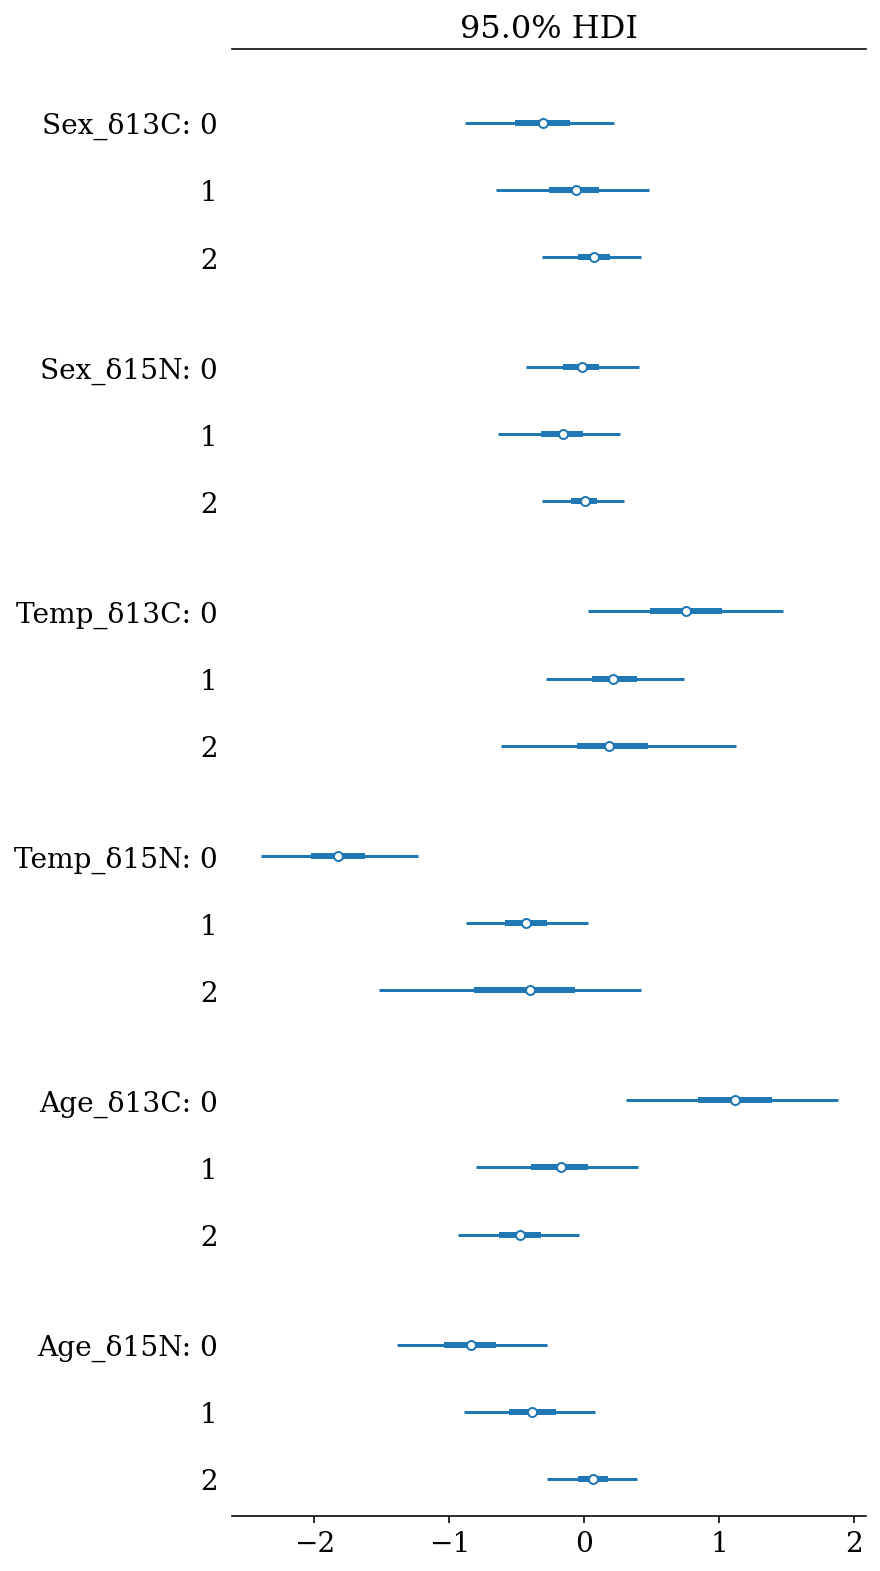

In [35]:
#| label: fig-forestboth
#| fig-cap: "Forest plot summarising the effects of the covariates on d15N and d13C values."
az.plot_forest(full_mod, hdi_prob = 0.95, var_names = '_δ', filter_vars = 'like', combined = True);
#plt.savefig(output_dir+'/figures/d13C_forestplot.pdf', format = 'pdf', bbox_inches = 'tight')

We can also directly evaluate the $P(\beta \neq 0)$, based on that if $P(\beta < 0)$ or $P(\beta > 0) \approx 50\%$ the $P(\beta \neq 0)$ is very low (50% of the distribution on either side of 0).

#### Sexes <a class="anchor" id="Sex"></a>

In general, the effect is small, with probabilities smaller than 75% in most cases. The only exception was in $\delta^{13}C$ for *H. dipterus* with $P(\beta < 0) \approx 90\%$, suggesting that females possibly had more coastal habits than males ($\bar{\beta} = -0.32$‰).

- Interpretation:
    - $\delta^{13}C_h = \delta^{13}C + \beta*0 = \delta^{13}C$
    - $\delta^{13}C_m = \delta^{13}C + \beta*1 = \delta^{13}C - 0.32$‰; *i.e.*, males had more negative values.

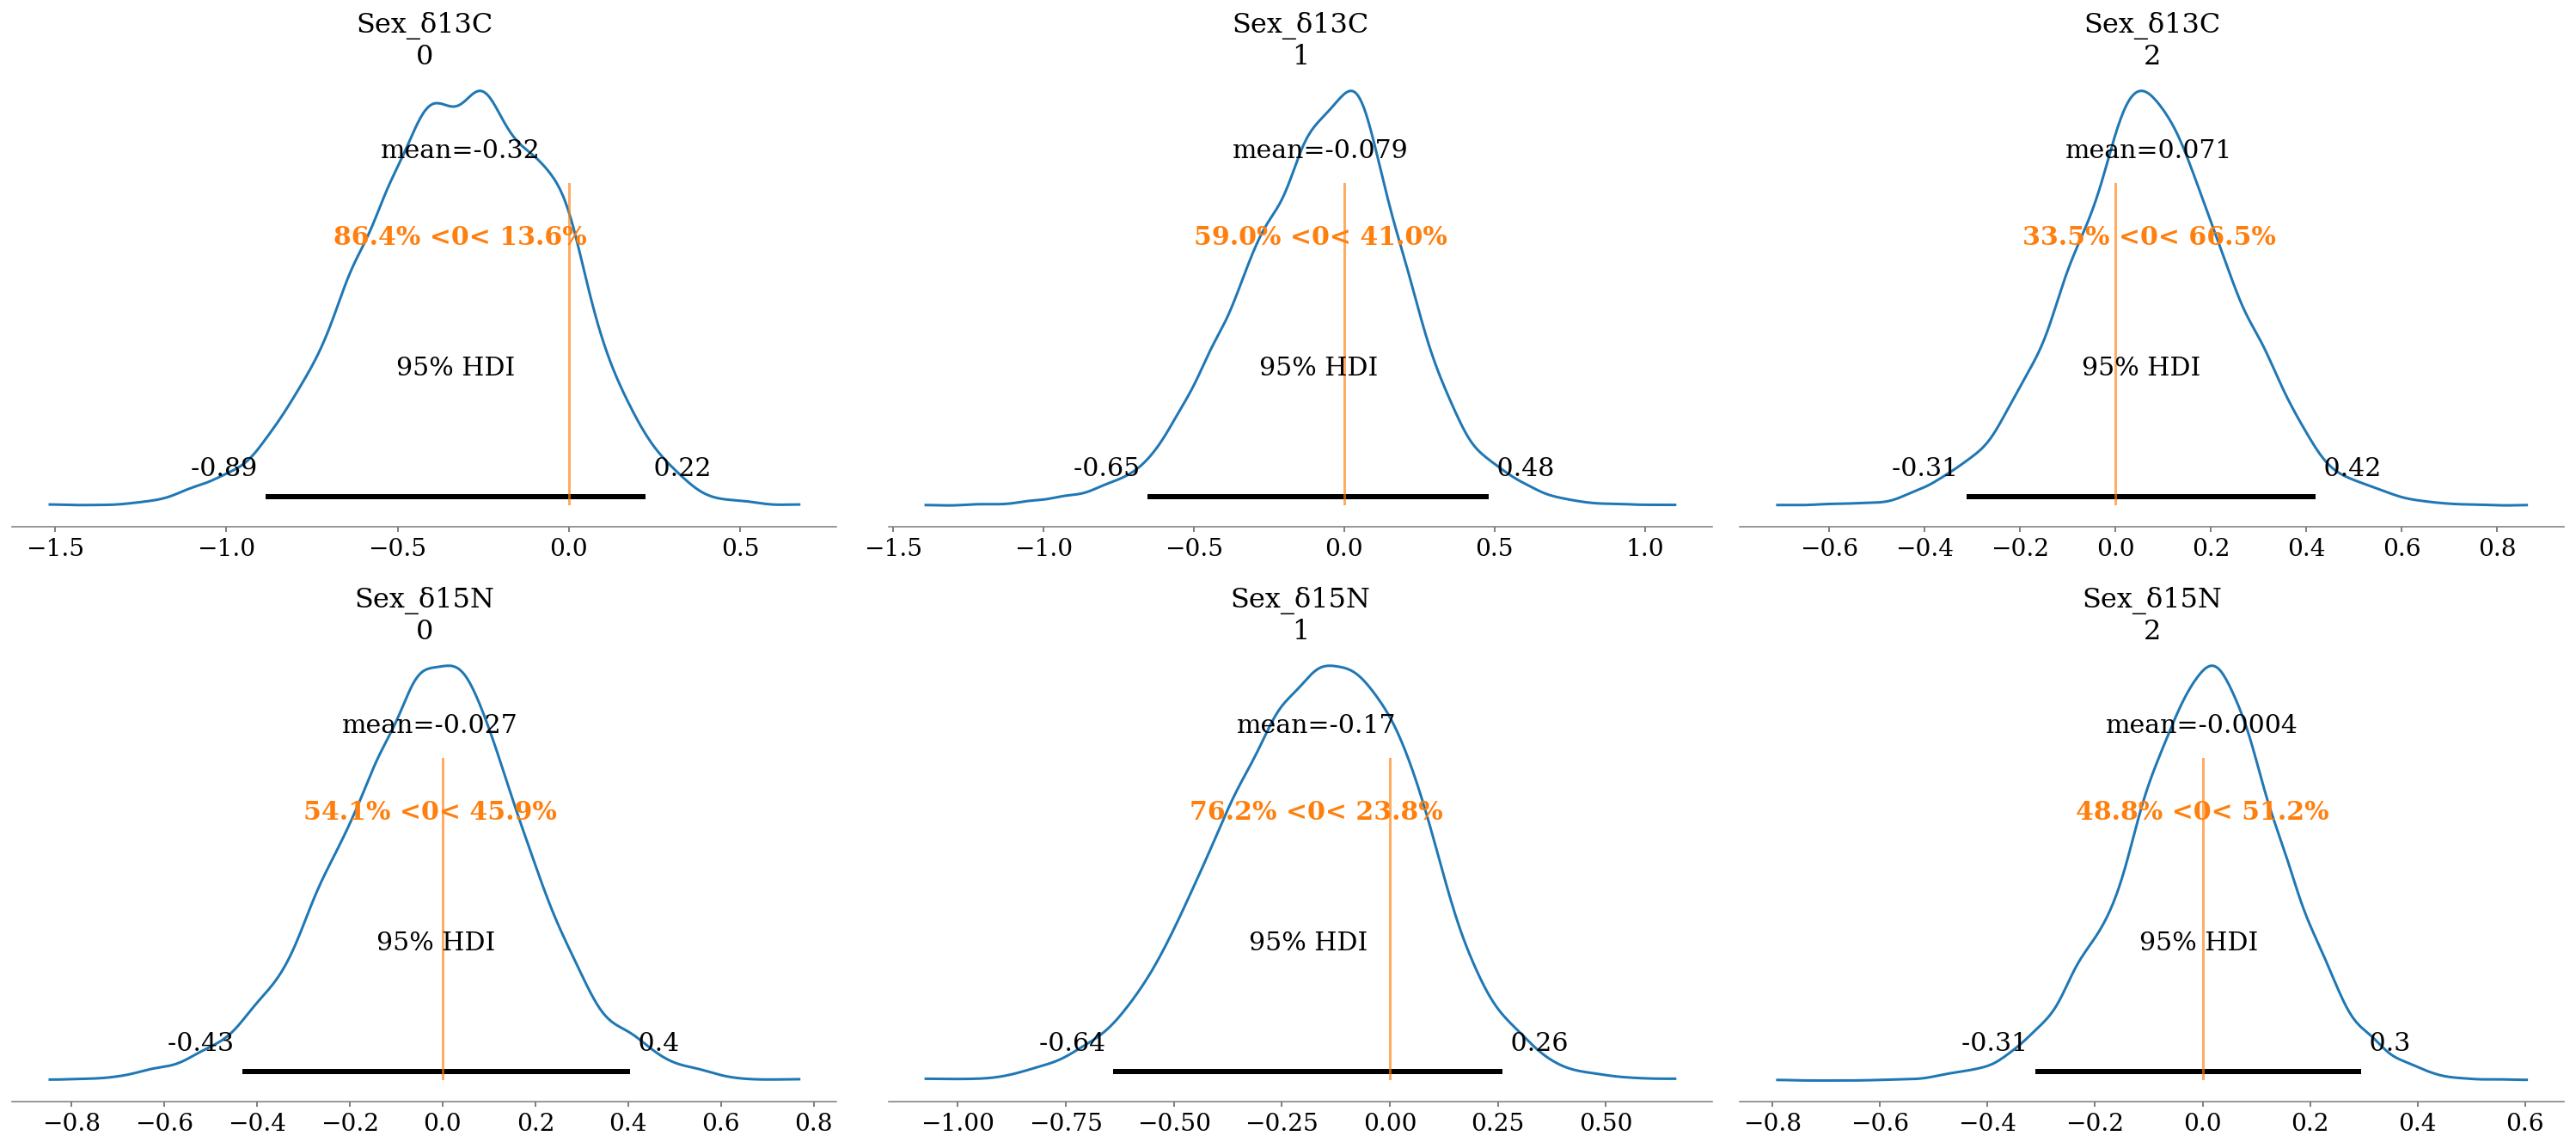

In [36]:
#| label: fig-posteriorsex
#| fig-cap: "Posterior distributions of the effect of the sex."
az.plot_posterior(full_mod, var_names = 'Sex', filter_vars = 'like', ref_val = 0, hdi_prob = 0.95);

#### Season <a class="anchor" id="Season"></a>
The effect of the season was more evident, with $P(\beta < 0 \lor \beta > 90)\%$ in most comparisons:

- $\delta^{13}C$:
    - *H. dipterus*: Cold season with less negative values than the warm season, suggesting more oceanic habits during the latter.
        - $\delta^{13}C_c = \delta^{13}C$
        - $\delta^{13}C_f = \delta^{13}C + \beta$; cold season with less negative values.
        
- $\delta^{15}N$: The three species showed less positive values during the cold season in relation to the warm season, which suggests that their prey had a higher trohpic position during the latter.
    - $\delta^{13}C_c = \delta^{13}C$
    - $\delta^{13}C_f = \delta^{13}C - \beta$; cold season with less positive values.

The lowest $P(\beta < 0 \lor \beta > 90)\%$ were found for *N. entemedor* ($P \approx 70\%$) and *R. steindachneri* ($P \approx 60%$) in $\delta^{13}C$.

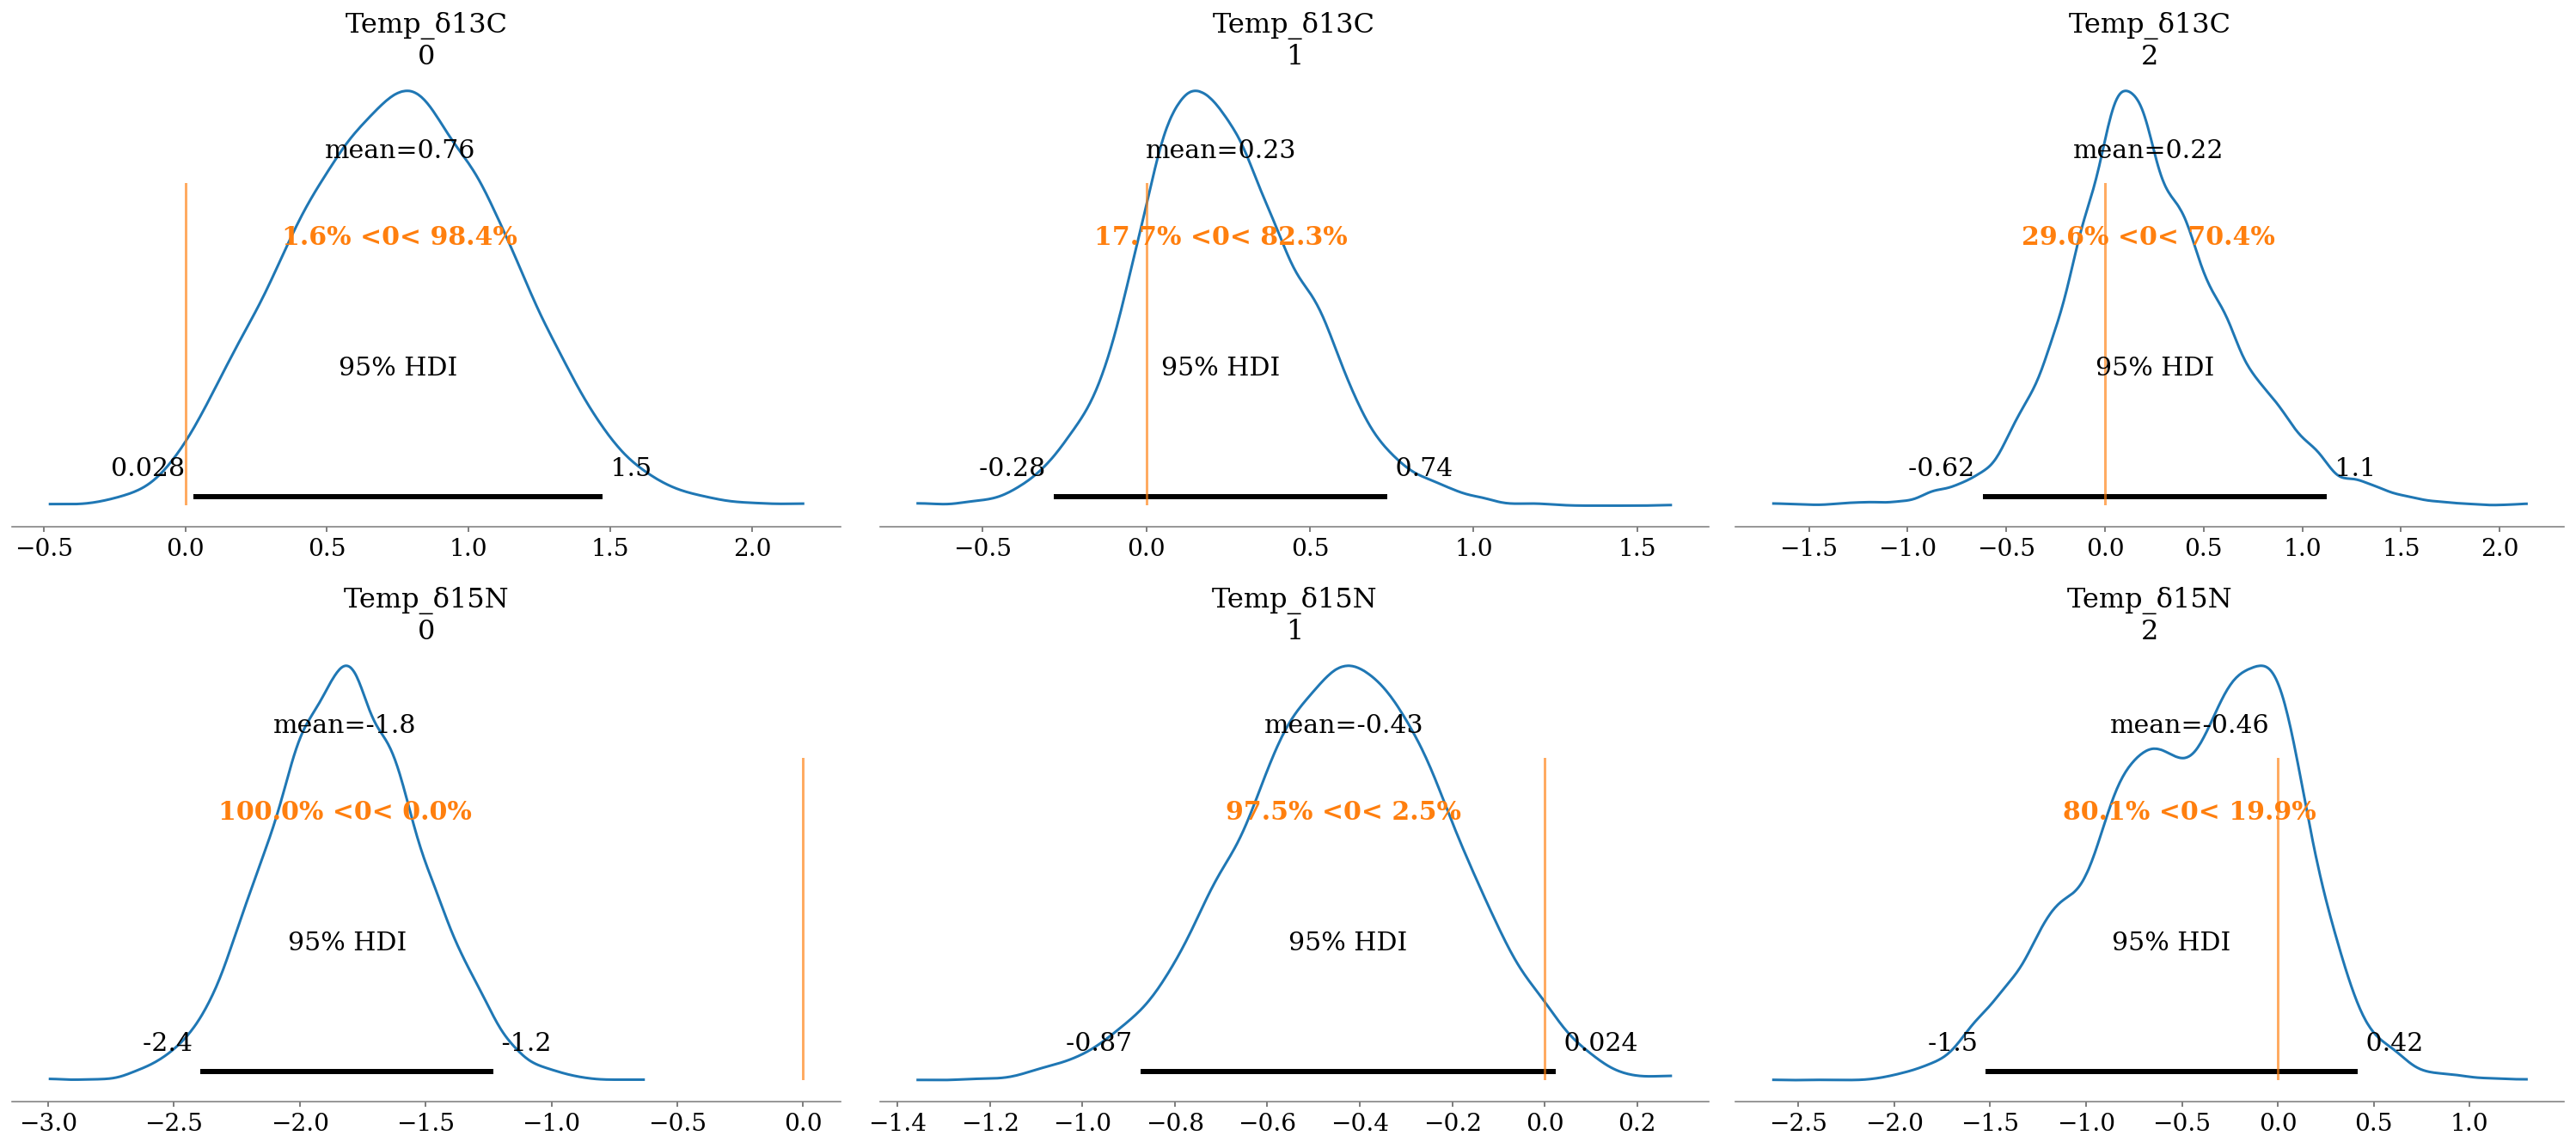

In [37]:
#| label: fig-posteriorseason
#| fig-cap: "Posterior distributions of the effect of the season."
az.plot_posterior(full_mod, var_names = 'Temp', filter_vars = 'like', ref_val = 0, hdi_prob = 0.95);

#### Maturity stages <a class="anchor" id="Age"></a>
There were high probabilities of differences between age categories, with the exception of *R. steindachneri* en $\delta^{15}N$ ($P(\beta>0) \approx 56\%$). The rest of the comparisons had similar trends, in the sense that juveniles had lower values in both isotopes, suggesting more oceanic habitats and lower trophic positions. The only exception was *H. dipterus* in $\delta^{13}C$, whose juveniles had more coastal habits (less negative values).

- Interpretation a):
    - $\delta^{13}C$:
        - $\delta^{13}C_a = \delta^{13}C$
        - $\delta^{13}C_j = \delta^{13}C - \beta$; juveniles had more negative values.
    - $\delta^{15}N$:
        - $\delta^{13}C_a = \delta^{15}N$
        - $\delta^{13}C_j = \delta^{15}N - \beta$; juveniles had less positive values.
        
- Interpretation b):
    - $\delta^{13}C_a = \delta^{13}C$
    - $\delta^{13}C_j = \delta^{13}C + \beta$; juveniles had more positive values.

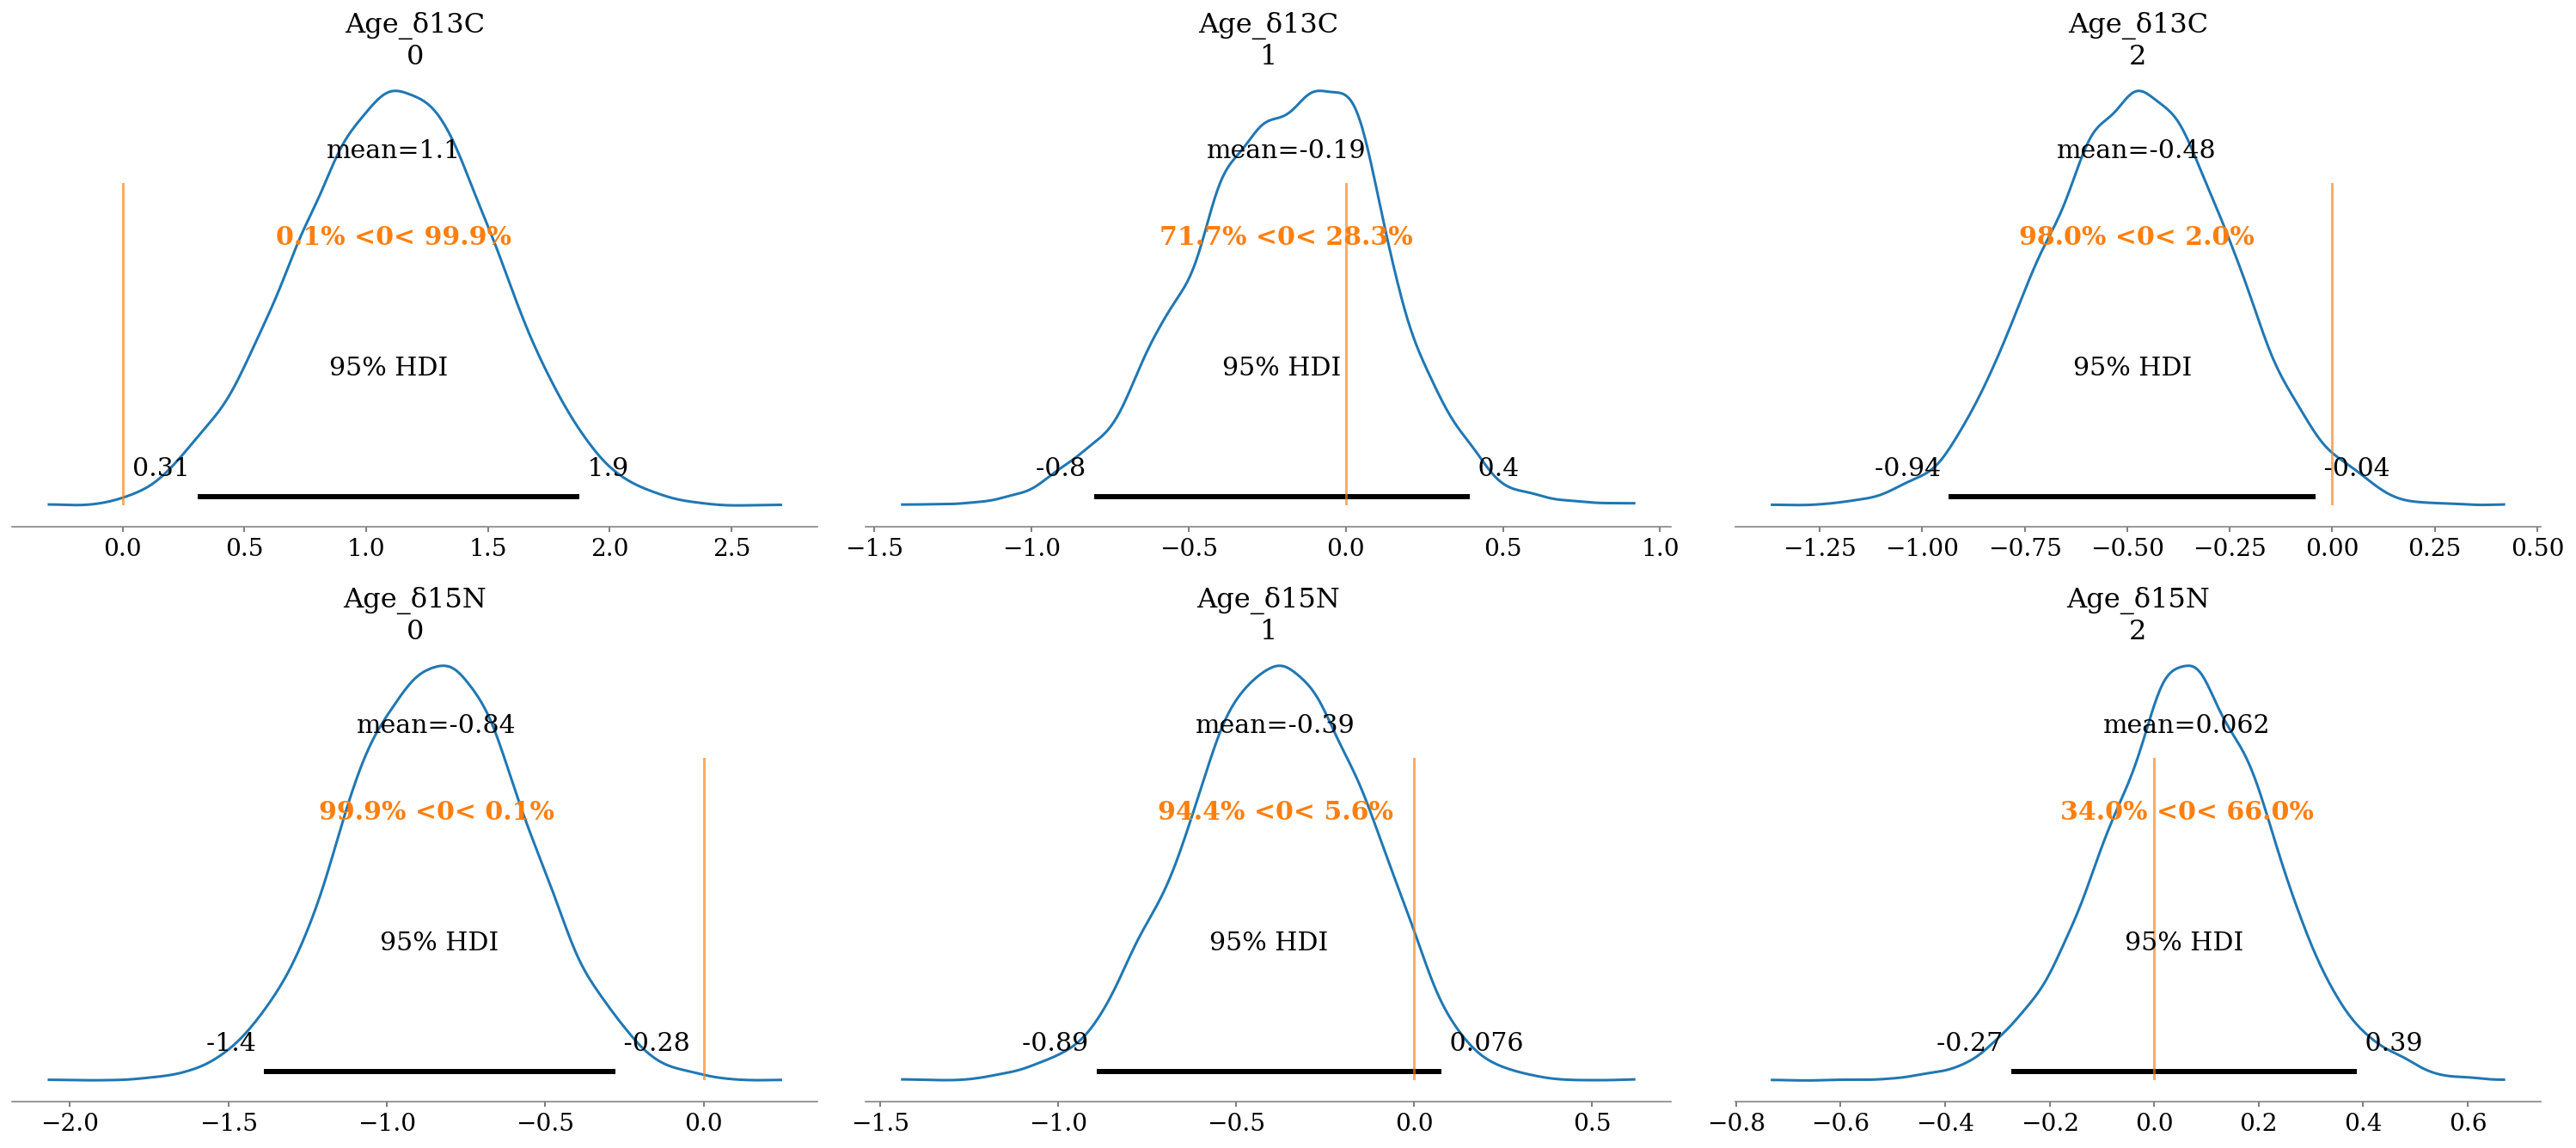

In [38]:
#| label: fig-posteriormaturity
#| fig-cap: "Posterior distributions of the effect of the maturity stage."
az.plot_posterior(full_mod, var_names = 'Age', filter_vars = 'like', ref_val = 0, hdi_prob = 0.95);

#### Isotopic mean comparison between species <a class="anchor" id="Comparisons"></a>

Since in the process we also estimated the posterior distributions of the means for each species, we can also directly compare them by simply substracting them:

In [39]:
def compare_posteriors(mod, labels, pars = ['µδ13C', 'µδ15N'], isos = ['$\delta^{13}C$', '$\delta^{15}N$'], save = False):
    from itertools import combinations
    # Get every comparison
    spp = [i for i, sp in enumerate(labels)]
    comps = list(combinations(spp, 2))
    # Create a figure with two spaces for each combination
    for i, comp in enumerate(comps):
        _, ax = plt.subplots(1, 2, figsize = (10,6), constrained_layout = False,
                             sharex = False, sharey = False)
        # For each parameter (isotope):
        for j,par in enumerate(pars):
            # Calculate the difference between posterior distributions
            Diff = mod.posterior[par][:,:,comp[0]] - mod.posterior[par][:,:,comp[1]]
            # Plot the difference, show the median of the distribution and P(Diff < 0 or Diff > 0)
            az.plot_posterior(Diff, ref_val = 0, hdi_prob = 0.95, point_estimate = 'mean', ax = ax[j])
            # Title for each panel is the isotope
            ax[j].set_title(f'{isos[j]}')
            # The title for each pair of comparisons is the pair of species
            plt.suptitle(f'{labels[comp[0]]} vs. {labels[comp[1]]}')
            if save is True:
                plt.savefig(output_dir+'/figures/'+f'{labels[comp[0]]} vs. {labels[comp[1]]}.pdf',
                            format = 'pdf',
                            bbox_inches = 'tight')

In the following figures we can observe that probabilities of mean differences were high in every comparison. Summarising:

- $\delta^{13}C$
    - *N. entemedor* > *H. dipterus* ($P = 100\%$)
    - *H. dipterus* > *R. steindachneri* ($P \approx 99\%$)
    - *N. entemedor* > *R. steindachneri* ($P = 100\%$)
    
- $\delta^{15}N$
    - *N. entemedor* < *H. dipterus* ($P = 100\%$)
    - *H. dipterus* > *R. steindachneri* ($P \approx 100\%$)
    - *N. entemedor* > *R. steindachneri* ($P = 100\%$)

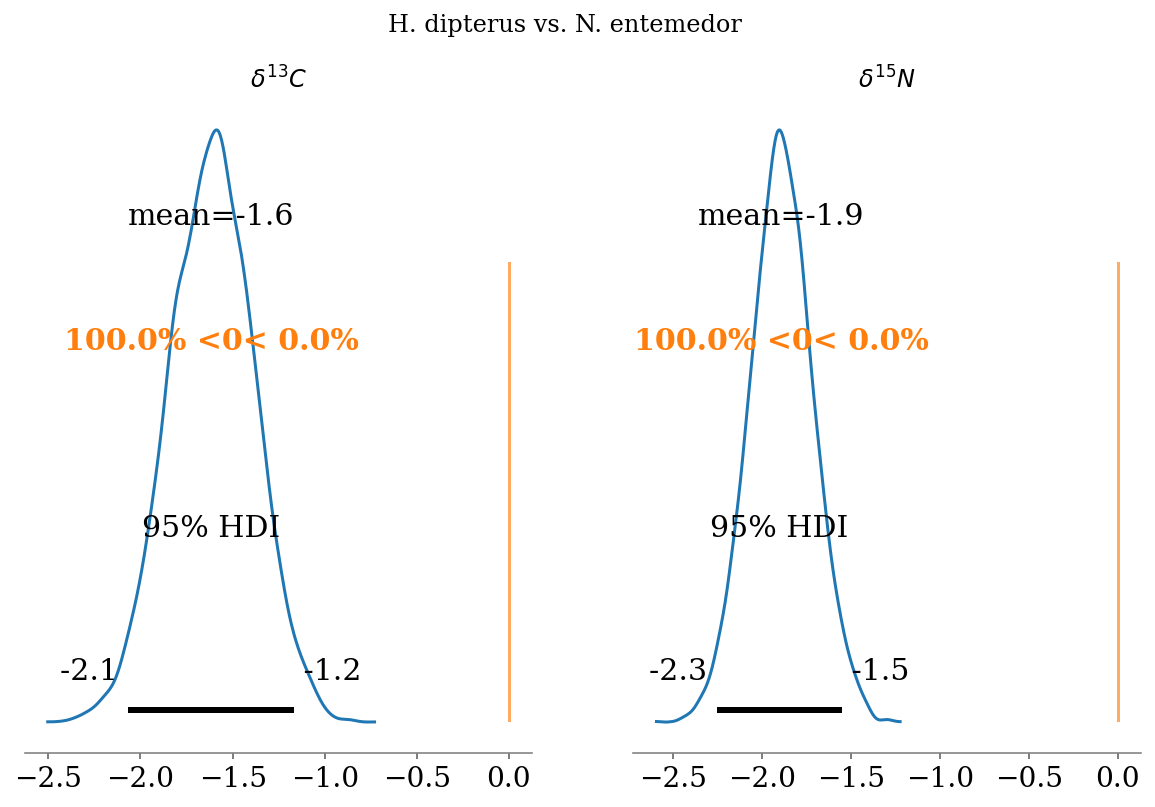

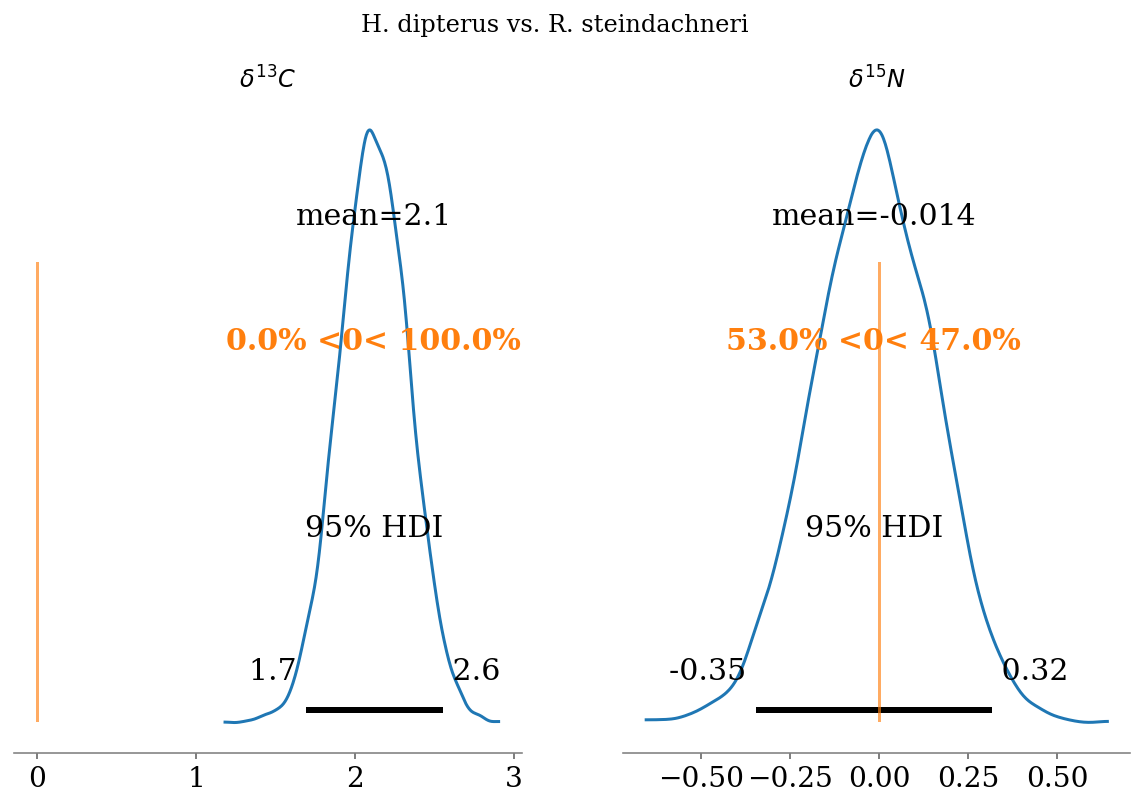

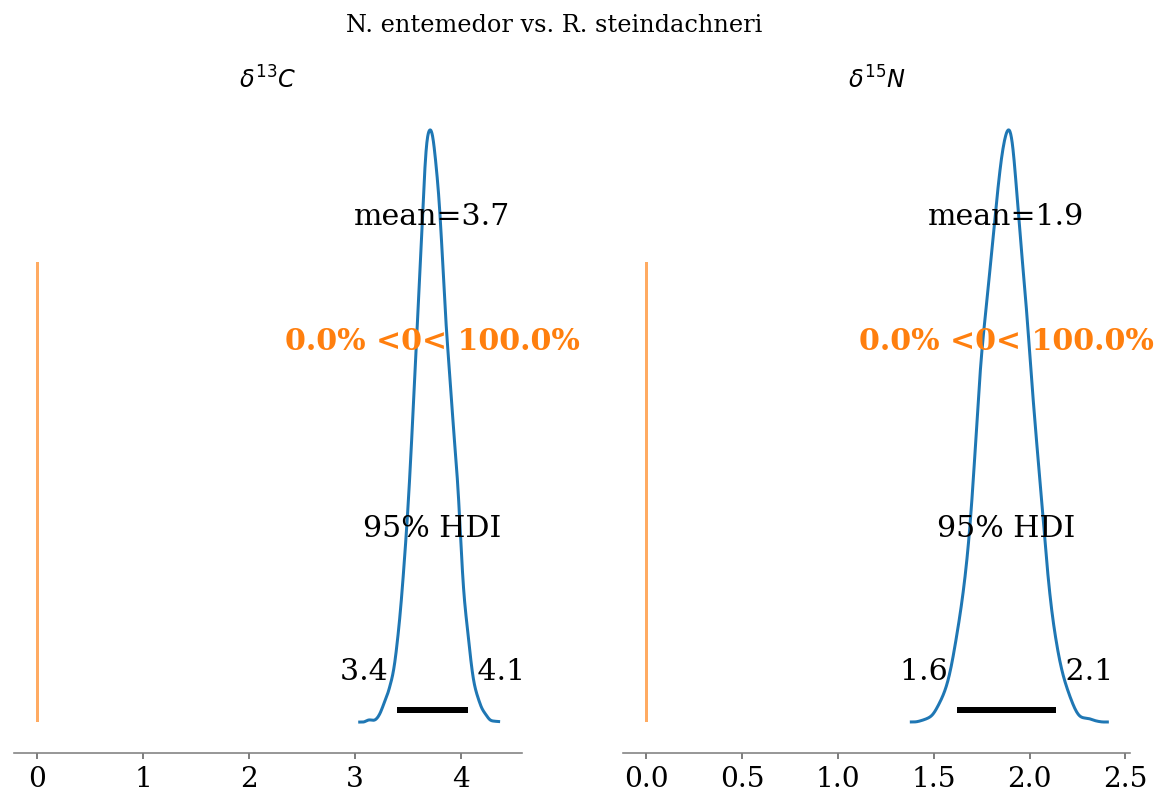

In [40]:
#| label: fig-posteriordiffs
#| fig-cap: "Posterior distributions of the differences between mean isotopic values among species."
#| fig-subcap: ""
compare_posteriors(mod = full_mod, labels = ['H. dipterus', 'N. entemedor', 'R. steindachneri'], save = False)

### Bivariate Posterior Distribution <a class="anchor" id="PosteriorJoint"></a>

In [41]:
def plot_posteriors(data, mod, labels = None, group_col = 'sp', iso_cols = ['d13c', 'd15n'],
                    palette = 'Paired', shade = True,
                    pars = ['µδ13C', 'µδ15N'], isos = ['$\delta^{13}C$', '$\delta^{15}N$']):
    from matplotlib.ticker import MaxNLocator
    # To avoid re-indexing every time
    x = iso_cols[0]
    y = iso_cols[1]
    
    # Empty Data Frame to store the posterior samples
    samples = pd.DataFrame()
    
    # Unique values of the group column to cicle through
    groups = data[group_col].unique()
    
    # Define limits of the plot
    xlim = (data[x].min() - 0.5, data[x].max() + 0.5)
    ylim = (data[y].min() - 0.5, data[y].max() + 0.5)
    
    # Form a Data Frame with the posterior samples for each isotope
    shape = mod.posterior[pars[0]].shape
    for group in groups:
            temp = pd.DataFrame({'d13c':mod.posterior[pars[0]][:,:,group].values.reshape(shape[0]*shape[1]),
                                 'd15n':mod.posterior[pars[1]][:,:,group].values.reshape(shape[0]*shape[1]),
                                 group_col: group})
            samples = samples.append(temp, ignore_index = False)
            
    samples = samples.reset_index(drop = True)
    
    # Map value labels to a new column (if provided)
    if type(labels) is dict:
        data['Group'] = data[group_col].map(labels)
        samples['Group'] = samples[group_col].map(labels)
        group_col = 'Group'
    
    # Plot the joint posterior distribution and its marginals
    grid = sns.JointGrid(x = x, y = y, data = data, xlim = xlim, ylim = ylim)
    g = grid.plot_joint(sns.scatterplot, hue = group_col, palette = palette, data = data)
    sns.kdeplot(x = samples[iso_cols[0]], shade = True, thresh = 0.05, hue = samples[group_col], 
                ax = g.ax_marg_x, palette = palette, legend = False)
    sns.kdeplot(y = samples[iso_cols[1]], shade = True, thresh = 0.05, hue = samples[group_col], 
                ax = g.ax_marg_y, palette = palette, legend = False)
    sns.kdeplot(x = samples[iso_cols[0]], y = samples[iso_cols[1]], shade = shade, thresh = 0.05, 
                hue = samples[group_col], palette = palette, legend = True, cbar= False, 
                alpha = 0.7, ax = g.ax_joint)
    
    # Change the appearance of the plot
    g.ax_joint.set_xlabel(isos[0])
    g.ax_joint.set_ylabel(isos[1])
    g.ax_joint.xaxis.set_major_locator(MaxNLocator(5))
    g.ax_joint.yaxis.set_major_locator(MaxNLocator(5))   

Given that both isotopes were modeled at the same time, we can plot the joint posterior mean distribution, which is non-orhtogonal as if both isotopes were independent from one another (separate Generalized Linear Models or independent null hypothesis testing). It is important to remark that the means are not in the centroid of each group. This is a favorable consequence of having used Student-T distributions for the parameters and likelihood instead of normal distributions. By stablishing that extreme values have a higher probability than in a normal distribution, the effect of the more extreme values is disregarded or, in another words, in a normal distribution they have low probabilities and, hence, each point is given a heavier weight.

This consequence is why using heavy-tailed distributions is called robust regression. In [this example](https://twiecki.io/blog/2013/08/27/bayesian-glms-2/) the effect is shown in a linear regression with a continuous covariate, in which the robust estimation of the parameters is not "deceived" by the more extreme values on the y variable and posterior predictive lines are closer to the real line than those of the "normal" regression.

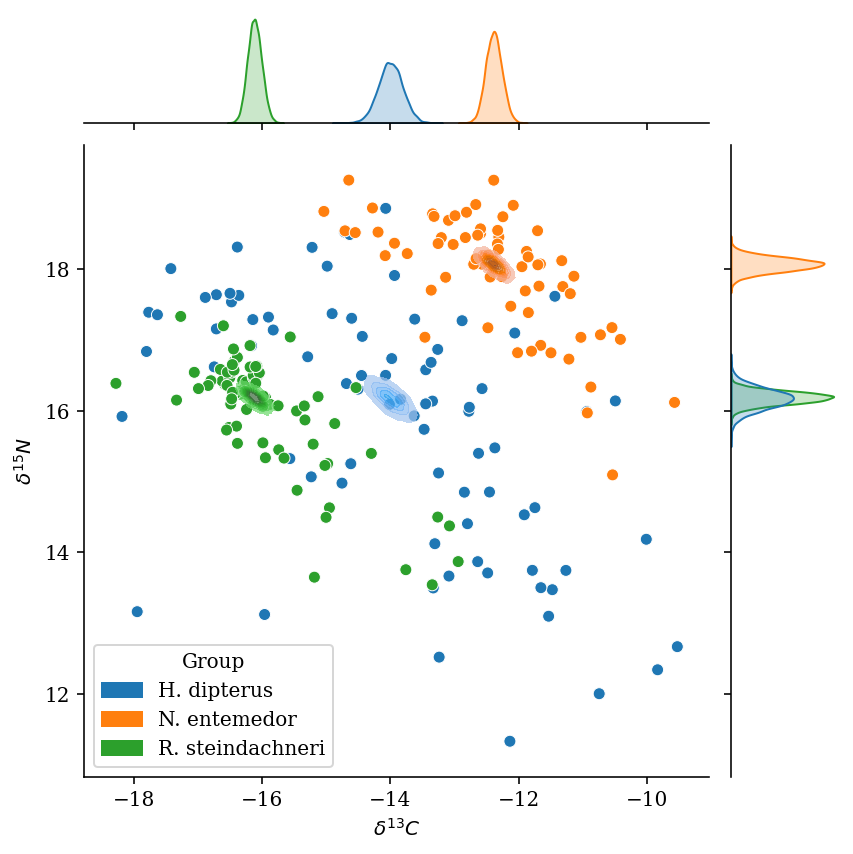

In [42]:
#| label: fig-posteriorbiv
#| fig-cap: "Bivariate posterior distributions of the mean isotopic values."
plot_posteriors(data = glm_data, mod = full_mod,
                labels = {0: 'H. dipterus', 1: 'N. entemedor', 2: 'R. steindachneri'},
                palette = colors[0:3])
#plt.savefigoutput_dir+'/figures/posterior_means.pdf", format = 'pdf', bbox_inches = 'tight')

In [43]:
print(f'elapsed = {datetime.now()-start}')

elapsed = 0:20:08.620410


In [44]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Feb 12 2023

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.19.0

theano    : 1.1.2
numpy     : 1.19.4
seaborn   : 0.11.0
arviz     : 0.11.2
pandas    : 1.1.5
pymc3     : 3.11.2
matplotlib: 3.3.3

Watermark: 2.1.0

